In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from glob import glob
from pprint import pprint
#from process import process_one_file
#print (glob('*.xy'))  #['file1.txt','file2.txt','file3.txt']
from scipy.stats import pearsonr

In [2]:
# commented for py3 testing
# from map_pdf_import import *

import pickle as cPickle

In [5]:
# from functions.array_process_functions import *

from diffpy.pdfgetx.functs import loadData
from diffpy.pdfgetx.pdfgetter import PDFGetter
from diffpy.srfit.pdf.characteristicfunctions import lognormalSphericalCF, sphericalCF

from numpy import pi

#from pyobjcryst.crystal import CreateCrystalFromCIF

from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.srfit.fitbase import Profile
from diffpy.srfit.fitbase import FitContribution, FitRecipe
from diffpy.srfit.fitbase import FitResults

#import cPickle as pickle

# from gaussianrecipe import scipyOptimize

from scipy.optimize.minpack import leastsq
from scipy.optimize import fmin

In [6]:
import seaborn as sns
# usage ex: sns.set_style("whitegrid")
# sns.set()
sns.set_style("ticks", {'grid.linestyle': '--',
                            'axes.linewidth': 2,
                            'grid.linewidth': 0.01,
                            'axes.edgecolor': '0.8'})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})

#Annotation formatting

bbox_props = dict(boxstyle="round", fc="w", ec="0.8", alpha=1)
bbox_props_alt = dict(boxstyle="round4", fc="white", ec="0.1", alpha=1)
bbox_props_alt2 = dict(boxstyle="round4", fc="red", ec="0.1", alpha=0.2)
bbox_props_alt3 = dict(boxstyle="round4", fc="blue", ec="0", alpha=0.2)

In [7]:
def bSeabornStyle(ticks=False, cycle='simon', context='notebook', f_scale=1, a_scale=1,
                  l_width=1, m_size=1, xt_col='black'):
    sns.reset_orig()
    if ticks==False:
        sns.set_style("whitegrid")
    else:
        sns.set_style("ticks")

    sns.set_style({
    'grid.linestyle': '--',
    'grid.color': 'b2b2b2',
    'axes.linewidth': (a_scale*1.75),
    'axes.labelcolor':'black',
    'axes.edgecolor': 'black',
    'xtick.color': xt_col,
    'ytick.color': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    })

    sns.set_context(context, font_scale=(f_scale*1.5),
                    rc={"lines.linewidth": (l_width*2),
                        "lines.markersize":(m_size*5),})
    mpl.rcParams['font.family']='Arial'
    mpl.rcParams['mathtext.fontset'] = 'stixsans'
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['figure.dpi'] = 240
    mpl.rcParams['figure.figsize'] = 9, 6
    mpl.rcParams['grid.linewidth'] = 0.5
    mpl.rcParams['savefig.bbox'] = 'tight'


    if cycle=='simon':
        simonCycle = ["#0B3C5D", "#062F4F", "#328CC1", "#D9B310", "#984B43", "#B82601",
                 "#57652A", "#76323F", "#626E60", "#AB987A", "#C09F80", "#b0b0b0ff"]
        sns.set_palette(simonCycle)
    elif cycle=='simon2':
        simonCycle2 = ["#0B3C5D", "#B82601",  "#1c6b0a","#328CC1", "#062F4F", "#D9B310", "#984B43",
                 "#76323F", "#626E60", "#AB987A", "#C09F80", "#b0b0b0ff"]
        sns.set_palette(simonCycle2)
    else:
        # Use another SNS preset: deep, muted, bright, pastel, dark, colorblind
        sns.set_palette(cycle)
bSeabornStyle(ticks=True, cycle='simon2')

## Utils1

In [21]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os


#from diffpy.pdfgetx.pdfgetter import PDFGetter
## for import, conversion functions
#function to convert from 2theta to Q in AA^-1
def theta2_to_q(theta2_array,wavelength):
    q_grid = np.sin(theta2_array*(np.pi/180/2))*((4*np.pi)/wavelength)
    return q_grid
#function to convert from Q to 2theta in AA^-1
def q_to_theta2(q_array,wavelength):
    theta2_grid =np.degrees(np.arcsin(((q_array*wavelength)/(np.pi*4))))*2
    return theta2_grid

def load_data(filepath):
    data1 = np.genfromtxt(filepath+'.chi',skip_header=8).T # transpose
    q = np.array(data1[0])
    I = np.array(data1[1])
    return q, I

def scalebtoa(ar,ag,bg,rmin=8,rmax=14): # rmin and rmax are refirring to q in this version
    """scale the G(r) B to A and return rescaled B

    arguments
    ar - array of x-values (both datasets on the same grid) -
    ag - array of g values for curve A
    bg - array of g values for curve B
    rmin - float of lower bound on range for rescaling
    rmax -  float on upper bound on range

    return
    rescaled bg
    """


    p=[1.0]
    # set the range
    rminit=np.where(ar>rmin)
    rmaxit=np.where(ar>rmax)
    rmini = rminit[0][0]
    rmaxi = rmaxit[0][0]

    e=lambda p: ((ag[rmini:rmaxi]-bg[rmini:rmaxi]*p[0])**2).sum();
    pfit = fmin(e,p,callback=None);
#     print "scale = ",pfit[0]
    rescaledb = bg*pfit[0];

    return rescaledb;

def subtract_background(basename,qgrid_data,I,background_path,savedir,scale=True,scale_factor = 1):

    #generate a np array from file
    qgrid_bgr,I_bgr = np.genfromtxt(background_path,skip_header=8).T # transpose

    #create savedir folder
    if not os.path.exists(savedir):
            os.makedirs(savedir)

    #reinterpolate the background
    I_reinterp_bgr = np.interp(qgrid_data, qgrid_bgr, I_bgr) # np.interp(target q-grid, q-grid, data to interpolate)

    ## Perform scaling then subtraction
    while scale==True:
        print("Background scaling - {}".format(scale_factor))
#         I_rescaled_bgr = scalebtoa(qgrid_data,I,I_reinterp_bgr,rmin=8,rmax=14);
        I_rescaled_bgr = I_reinterp_bgr*scale_factor
        I_sub_resc = I - I_rescaled_bgr

        #stack the data together and save to .chi files
        stack = np.vstack((qgrid_data.T,I_sub_resc.T))
        np.savetxt(savedir+basename+'.chi',stack.T, delimiter='\t')

        return I_sub_resc
    else:
        ## Perform the subtraction
        I_sub = I - I_reinterp_bgr
        #stack the data together and save to .chi files
        stack = np.vstack((qgrid_data.T,I_sub.T))
        np.savetxt(savedir+basename+'.chi',stack.T, delimiter='\t')
        return I_sub

def make_PDF(basename,q,Iq,savedir_gr,composition = 'PtRu'):

    pdfgetter = PDFGetter()
    ##transform to PDF
    r, gr = pdfgetter(q, Iq, qmaxinst = 17, qmin = 0.8, qmax=17,
                      dataformat='Qnm', composition = composition,
                      rmin = 0.0, rmax = 100.0, rstep=0.01)

    ##save gr file
    stack_gr = np.vstack((r.T,gr.T))
    #print reduced_filename
    np.savetxt(savedir_gr+basename+'.gr',stack_gr.T,delimiter='\t')
    # np.savetxt(savedir+i,stack.T, delimiter='\t')

    ##plot data
    # fig, (ax1) = plt.subplots(1, 1, figsize=[10,4])
    # ax1.plot(r, gr, label=basename+' composition - '+composition)
    # ax1.legend()
    # ax1.set_xlim(1,50)
    return r,gr

def plotResults(recipe, pathname):
    """Plot the results contained within a refined FitRecipe."""
    # All this should be pretty familiar by now.
    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.8 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero

    pylab.figure()
    pylab.plot(r,g,'bo',label="G(r) Data")
    pylab.plot(r, gcalc,'r-',label="G(r) Fit")
    pylab.plot(r,diff,'g-',label="G(r) diff")
    pylab.plot(r,diffzero,'k-')
    pylab.xlabel("$r (\AA)$")
    pylab.ylabel("$G (\AA^{-2})$")
    pylab.legend(loc=1)
    pylab.savefig(pathname+'.eps', format='eps', bbox_inches='tight')
    #pylab.show()
    return


## function to calculate the z coordinate on a plane give x and y position
def plane_calibrated_distance(x,y):
    # plane formula is : 0.0064x + 0.0144y + 1440.0*detector_distance = 294.03096
    detector_distance = (0.0064*x + 0.0144*y - 294.03096)/-1440
    return detector_distance

In [9]:
## Reipe making
def arrayBinaryFCC(stru1, datname):

    profile = Profile()

    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=1.5, xmax = 20.0, dx = 0.01)
    
    generator_crystal1 = PDFGenerator("G1")
    
    generator_crystal1.setStructure(stru1, periodic=True)

    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal1)
    
    #     generator_crystal1.parallel(10)

    contribution.setProfile(profile, xname = "r")
    
    #     We will add a spherical form factor here later     
    from diffpy.srfit.pdf.characteristicfunctions import sphericalCF
    contribution.registerFunction(sphericalCF, name = "f")
    #     contribution.setEquation("s0 * (s1*G1 + s2*G2 + s3*G3*f + (1-s1-s2-s3)*G4)")
    #     contribution.setEquation("s0*G1")
    contribution.setEquation("s0*G1*f")
    
    
    recipe = FitRecipe()
    recipe.addContribution(contribution)
    
    qdamp = 0.0452 
    qbroad = 0.0170

    generator_crystal1.qdamp.value = qdamp
   
    generator_crystal1.qbroad.value = qbroad

    generator_crystal1.setQmax(24)
    generator_crystal1.setQmin(0.1)

    recipe.addVar(contribution.psize, 30, tag = "scale")
    recipe.addVar(contribution.s0, 1.0, tag = "scale")
 

    phase_crystal1 = generator_crystal1.phase

    lat1 = phase_crystal1.getLattice()

    recipe.newVar("PtRu", 3.9, tag = "lat")#.bounds = [0, 7]
    recipe.constrain(lat1.a, 'PtRu')
    recipe.constrain(lat1.b, 'PtRu')
    recipe.constrain(lat1.c, 'PtRu')
    
    # Get/refine atomic ADPs
    atoms1 = phase_crystal1.getScatterers()

    recipe.newVar("Pt_U1", 0.008, tag = "adp")#.bounds = [0, 7]
    recipe.newVar("Ru_U1", 0.008, tag = "adp")#.bounds = [0, 7]

    for atom in atoms1:
        if atom.element.title() == "Pt":
            recipe.constrain(atom.Uiso, "Pt_U1")
        if atom.element.title() == "Ru":
            recipe.constrain(atom.Uiso, "Ru_U1")

    
    # Add/refine delta parameters
    recipe.addVar(generator_crystal1.delta2, name = "delta2_crystal1", value = 4.47, tag = "d2")

  
    return recipe

def arrayFCC(stru1, datname,lattice_guess):

    profile = Profile()

    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=1.5, xmax = 30.0, dx = 0.01)
    
    generator_crystal1 = PDFGenerator("G1")
    
    generator_crystal1.setStructure(stru1, periodic=True)

    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal1)
    
    #     generator_crystal1.parallel(10)

    contribution.setProfile(profile, xname = "r")
    
    #     We will add a spherical form factor here later     
    from diffpy.srfit.pdf.characteristicfunctions import sphericalCF
    contribution.registerFunction(sphericalCF, name = "f")
    #     contribution.setEquation("s0 * (s1*G1 + s2*G2 + s3*G3*f + (1-s1-s2-s3)*G4)")
    #     contribution.setEquation("s0*G1")
    contribution.setEquation("s0*G1*f")
    
    
    recipe = FitRecipe()
    recipe.addContribution(contribution)
    
    qdamp = 0.0376 
    qbroad = 0.0199

    generator_crystal1.qdamp.value = qdamp
   
    generator_crystal1.qbroad.value = qbroad

    generator_crystal1.setQmax(25)
    generator_crystal1.setQmin(0.1)

    recipe.addVar(contribution.psize, 50, tag = "scale")
    recipe.addVar(contribution.s0, 1.0, tag = "scale")
 

    phase_crystal1 = generator_crystal1.phase

    lat1 = phase_crystal1.getLattice()

    recipe.newVar("Pt", lattice_guess, tag = "lat")#.bounds = [0, 7]
    recipe.constrain(lat1.a, 'Pt')
    recipe.constrain(lat1.b, 'Pt')
    recipe.constrain(lat1.c, 'Pt')
    
    # Get/refine atomic ADPs
    atoms1 = phase_crystal1.getScatterers()

    recipe.newVar("Pt_U1", 0.008, tag = "adp")#.bounds = [0, 7]
    for atom in atoms1:
        if atom.element.title() == "Pt":
            recipe.constrain(atom.Uiso, "Pt_U1")
    
    # Add/refine delta parameters
    recipe.addVar(generator_crystal1.delta2, name = "delta2_crystal1", value = 1, tag = "d2")

  
    return recipe

def fitCdSe(gr_filename):
    #!/usr/bin/env python
    # -*- coding: utf-8 -*-

    # We'll need numpy and matplotlib for plotting our results
    import numpy as np
    import matplotlib.pyplot as plt

    # A least squares fitting algorithm from scipy
    from scipy.optimize.minpack import leastsq

    # DiffPy-CMI modules for building a fitting recipe
    from diffpy.Structure import loadStructure
    from diffpy.srfit.pdf import PDFContribution
    from diffpy.srfit.fitbase import FitRecipe, FitResults

    # Files containing our experimental data and structure file
    dataFile = savedir_gr+gr_filename+'.gr'
    structureFile = "./structures/cdse.xyz"

    # The first thing to construct is a contribution. Since this is a simple
    # example, the contribution will simply contain our PDF data and an associated
    # structure file. We'll give it the name "cdse"
    cdsePDF = PDFContribution("CdSe")

    # Load the data and set the r-range over which we'll fit
    cdsePDF.loadData(dataFile)
    cdsePDF.setCalculationRange(xmin=1, xmax=20, dx=0.01)

    # Add the structure from our xyz file to the contribution, since the structure
    # model is non-periodic, we need to specify the periodic=False here to get the
    # right PDF
    cdseStructure = loadStructure(structureFile)
    cdsePDF.addStructure("CdSe", cdseStructure, periodic=False)

    # The FitRecipe does the work of managing one or more contributions
    # that are optimized together.  In addition, FitRecipe configures
    # fit variables that are tied to the model parameters and thus
    # controls the calculated profiles.
    cdseFit = FitRecipe()

    # give the PDFContribution to the FitRecipe
    cdseFit.addContribution(cdsePDF)

    # Here we create variables for the overall scale of the PDF and a delta2
    # parameter for correlated motion of neighboring atoms.
    cdseFit.addVar(cdsePDF.scale, 1)
    cdseFit.addVar(cdsePDF.CdSe.delta2, 5)

    # We fix Qdamp based on prior information about our beamline.
    cdseFit.addVar(cdsePDF.qdamp, 0.06, fixed=True)

    # Since we are calculating PDF from a non-periodic structure, we also need to
    # specify the Qmin to get he correct PDF. The value of Qmin could be the actual
    # Qmin in the experiment or the Qmin used in PDF transformation, or some value
    # related to the size and the shape of the structure model. Usually a value
    # in (0.5 ~ 1.0) will give reasonable results.
    cdsePDF.CdSe.setQmin(1.0)

    # The Qmax used in PDF transformation should also be specfied
    cdsePDF.CdSe.setQmax(17.0)

    # We create the variables of ADP and assign the initial value to them. In this
    # example, we use isotropic ADP for all atoms
    CdBiso = cdseFit.newVar("Cd_Biso", value=1.0)
    SeBiso = cdseFit.newVar("Se_Biso", value=1.0)

    # For all atoms in the structure model, we constrain their Biso according to
    # their species
    atoms = cdsePDF.CdSe.phase.getScatterers()
    for atom in atoms:
        if atom.element == 'Cd':
            cdseFit.constrain(atom.Biso, CdBiso)
        elif atom.element == 'Se':
            cdseFit.constrain(atom.Biso, SeBiso)

    # Now we create a zoomscale factor which stretches the structure model, this is
    # useful when you want to fit the bond length. Note that the relative position
    # of atoms are not changed during the refinements
    zoomscale = cdseFit.newVar('zoomscale', value=1.0)

    # Here is a simple we to assign the zoomscale to the structure. Note that this
    # only works for NON-PERIODIC structure
    lattice = cdsePDF.CdSe.phase.getLattice()
    cdseFit.constrain(lattice.a, zoomscale)
    cdseFit.constrain(lattice.b, zoomscale)
    cdseFit.constrain(lattice.c, zoomscale)

    # Turn off printout of iteration number.
    cdseFit.clearFitHooks()

    # We can now execute the fit using scipy's least square optimizer.
    print("Refine PDF using scipy's least-squares optimizer:")
    print("  variables:", cdseFit.names)
    print("  initial values:", cdseFit.values)
    leastsq(cdseFit.residual, cdseFit.values)
    print("  final values:", cdseFit.values)
    print()

    # Obtain and display the fit results.
    cdseResults = FitResults(cdseFit)
    print("FIT RESULTS\n")
    print(cdseResults)

    # Plot the observed and refined PDF.

    # Get the experimental data from the recipe
    r = cdseFit.CdSe.profile.x
    gobs = cdseFit.CdSe.profile.y

    # Get the calculated PDF and compute the difference between the calculated and
    # measured PDF
    gcalc = cdseFit.CdSe.evaluate()
    baseline = 1.1 * gobs.min()
    gdiff = gobs - gcalc

    # Plot!
    plt.figure()
    plt.plot(r, gobs, 'bo', label="G(r) data")
    plt.plot(r, gcalc, 'r-', label="G(r) fit")
    plt.plot(r, gdiff + baseline, 'g-', label="G(r) diff")
    plt.plot(r, np.zeros_like(r) + baseline, 'k:')
    plt.xlabel(r"$r (\AA)$")
    plt.ylabel(r"$G (\AA^{-2})$")
    plt.legend()

    plt.show()

## Set up paths to data

In [10]:
## Setup data processing
sample_name = "CdSe_wanda_array"
sample_directory = "./"

# Background Subtraction:
data_dir='./automasking_loop_CdSe/' #directory for unsubtracted data
path_to_bgr = "./automasking_loop_CdSe/20171031-182338_dx=-13.800mm_dy=19.950mm_cb0d83_001.chi" #path to background file
savedir = './start_with_mask_CdSe_results/' #directory for saving subtracted data

# Transform to PDF
file_dir = savedir  #directory for saving background subtracted .chi files
savedir_gr = savedir+'gr/'  #save directory for .gr

if not os.path.exists(savedir_gr): #creates the directory to save .gr
    os.makedirs(savedir_gr)

### Read the csv with the scan plan

In [11]:
array = np.genfromtxt('./meta/wandaHY1.csv',delimiter=',',dtype =None) #gen from txt can read in strings and makes them NaN
# print array[:,][:1]
# print array[:][:]

In [12]:
## create a list of filenames. Then strip everything related to the directory leaving only the file name
data_path = data_dir
allfiles = sorted(glob(data_path+'*.chi'))
# allfiles = [j.lstrip(data_dir) for j in allfiles]

Some filenames require a more creative stripping...

In [13]:
allfiles = [j.lstrip('./automasking_loop_CdSe') for j in allfiles] #strip path
#allfiles = [j.lstrip('integrated_files') for j in allfiles]
#allfiles = [j.lstrip('used_fc/') for j in allfiles]

pprint(allfiles[0:2])

['20171031-182338_dx=-13.800mm_dy=19.950mm_cb0d83_001.chi',
 '20171031-182619_dx=-15.100mm_dy=19.950mm_cb0d83_002.chi']


In [14]:
#for i in allfiles:
    #print(i[9:15])

### Break down the .csv and put every column into it's own dictionary

In [15]:
event_list = []

for i in range(len(array)):
    seq_num,diff_x,diff_x_user_setpoint,diff_y,diff_y_user_setpoint,pe1_image,pe1_stats1_total,shctl1,shctl1_user_setpoint,date,time = array[i]
#     fn, com, scan, pos, x, y = array[i]
    #fn = [j.strip('.chi') for j in fn]
    event_list.append(dict(number=seq_num, x=diff_x, y=diff_y,timestamp=time))

# For this to work the header of the exported sample table from XPD needs to be commented with a # 
# and the first column should look like this : #,...   

# pprint([x for x in event_list if x['composition'] == 'PtPb'])

In [16]:
## adding a decode step for python3 to get rid of the byte encoding
for d in event_list:
    d['timestamp'] = d['timestamp'].decode('utf-8')

In [17]:
#super clunky nested loop to associate filenames with the csv entries
for d in event_list:
    for i in allfiles:
        #print(d['timestamp'][1:7])
        if d['timestamp'][1:7] == i[9:15]:
            d['basename'] = i
            
pprint(event_list[0:2])

[{'basename': '20171101-003456_dx=13.200mm_dy=19.950mm_b1cf71_001.chi',
  'number': 1,
  'timestamp': "'003456'",
  'x': 13.200000000000001,
  'y': 19.949999999999999},
 {'basename': '20171101-003502_dx=11.900mm_dy=19.950mm_b1cf71_002.chi',
  'number': 2,
  'timestamp': "'003502'",
  'x': 11.9,
  'y': 19.949999999999999}]


## Prepare data for treatment

In [19]:
# strips the file extension from the basename. 
# The idea is to keep the file name consistent, but clean(f.x. no doulbe extensions).

for d in event_list:
    d['basename'] = d['basename'].strip('.chi')

In [22]:
## add distance to detector for all files
for d in event_list:
    # set the correct sample-detector distance based on the calculated plane using the function
    d['detector_distance'] = plane_calibrated_distance(d['x'],d['y'])

In [20]:
## add known compositional information
for d in event_list:
    d['composition']= 'CdSe'
#     print d['composition']

### Plot the measurement points

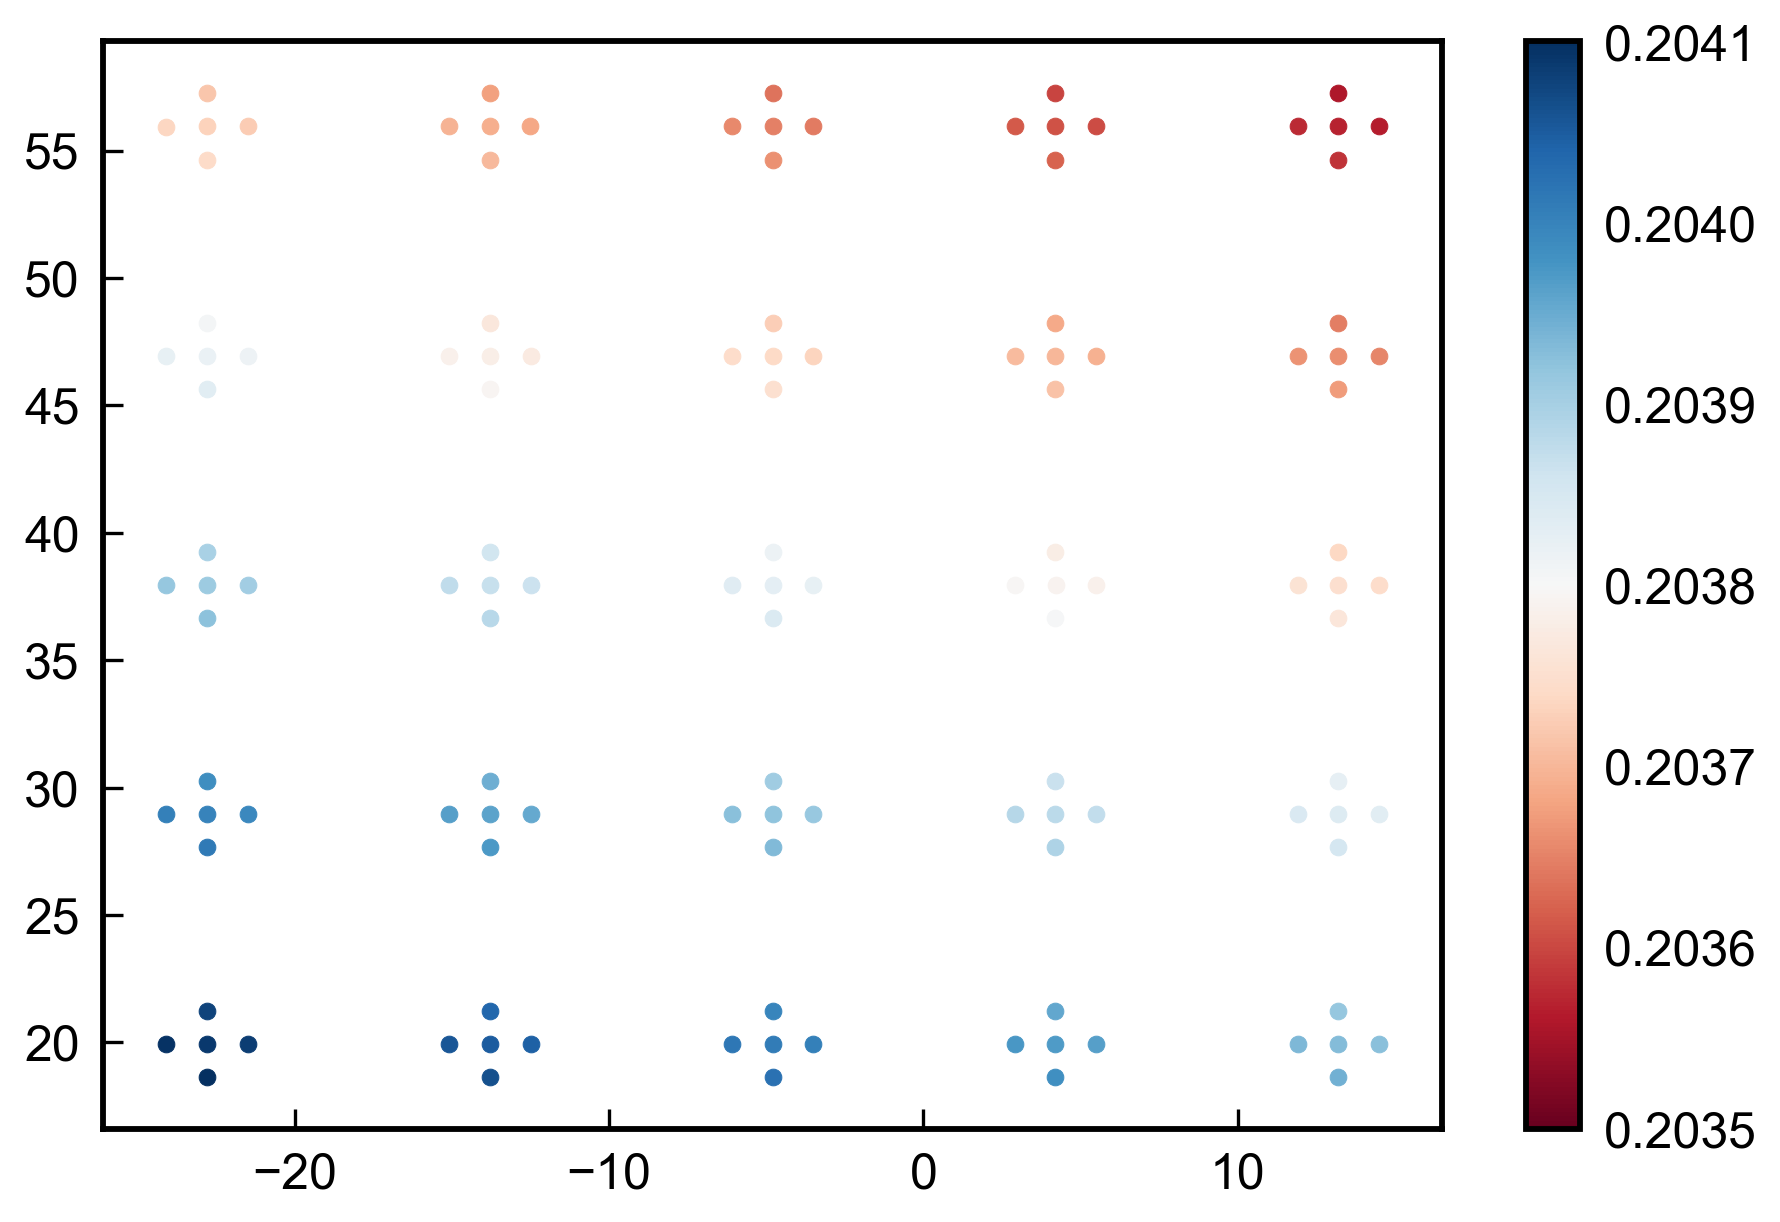

In [34]:
for d in event_list:
    plt.scatter(d['x'], d['y'], c=d['detector_distance'],cmap = 'RdBu',vmin=0.2035, vmax=0.2041)
plt.colorbar()

(0.202, 0.205)

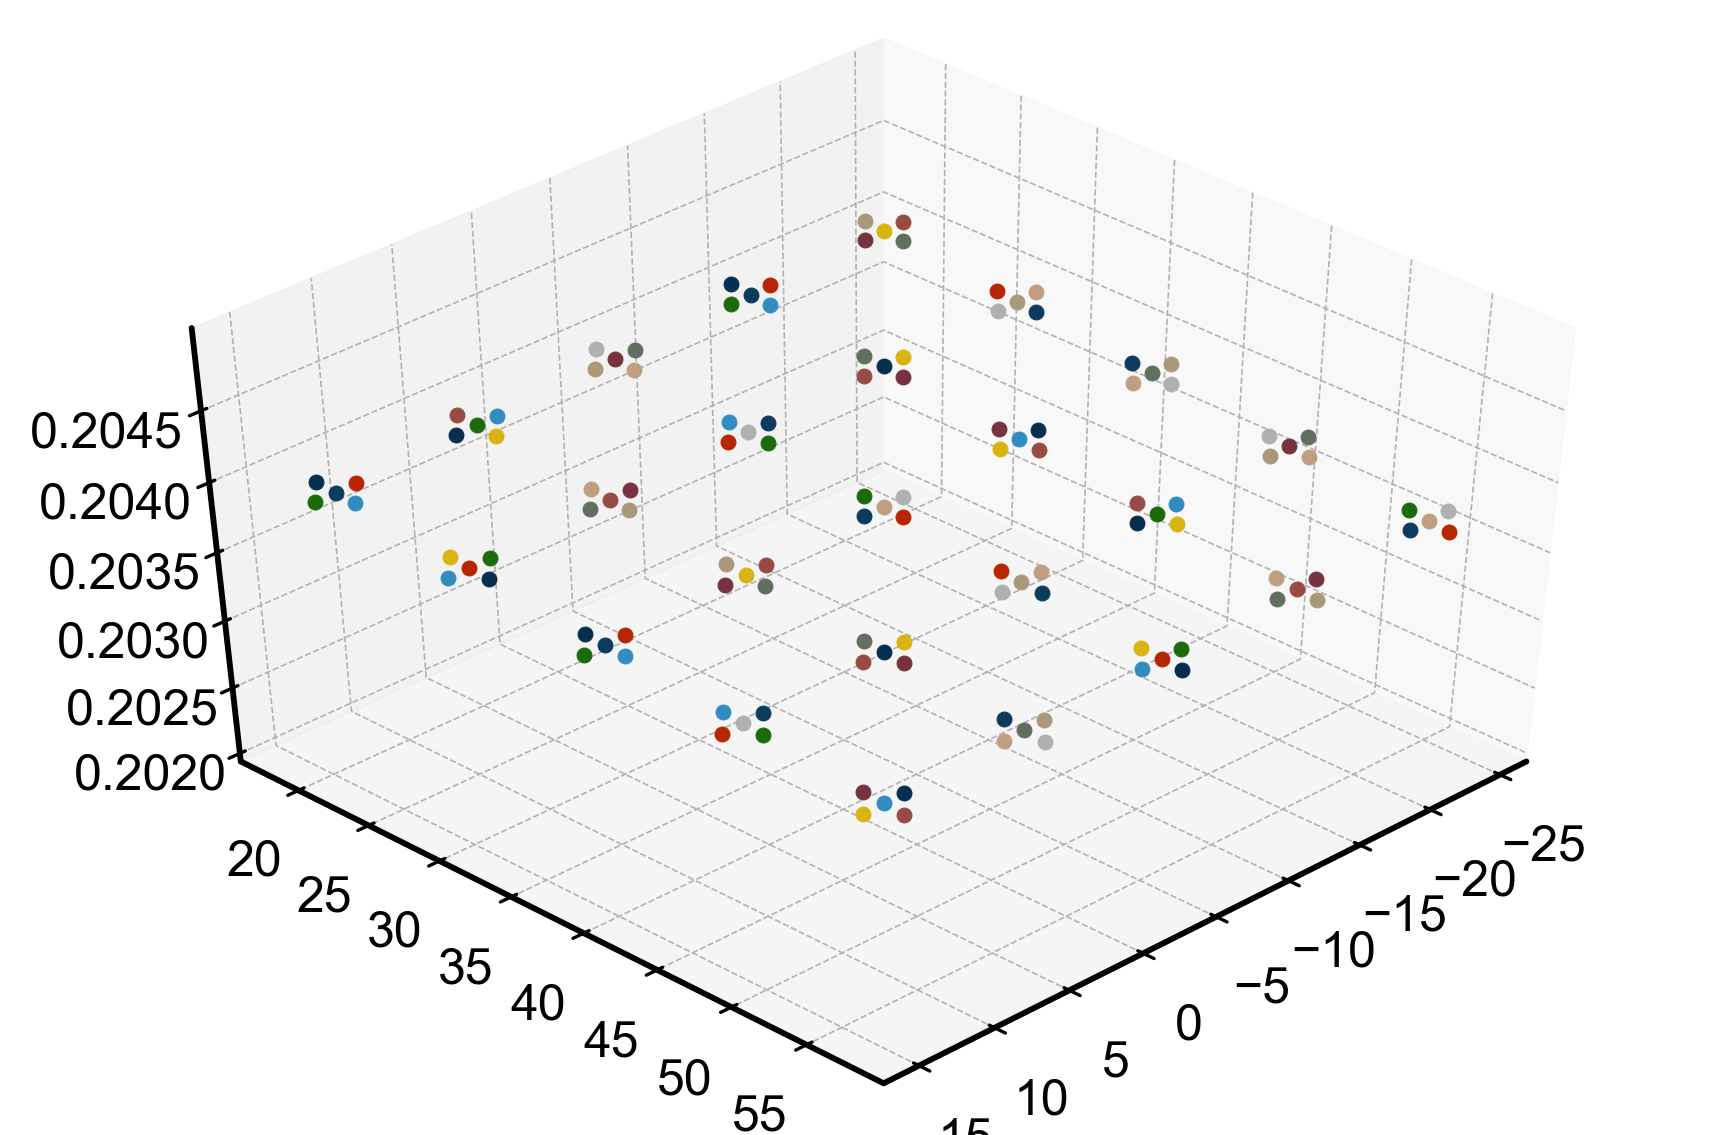

In [35]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for d in event_list:
    #print(d['x'],d['y'],d['detector_distance'])
    ax.scatter(d['x'],d['y'],d['detector_distance'])#, 'bo ',markersize=0.5,alpha= 0.2)

# plot the original points. We use zip to get 1D lists of x, y and z
# coordinates.
#ax.plot(*zip(p1, p2, p3, p4), color='r', linestyle=' ', marker='o')

# adjust the view so we can see the point/plane alignment
ax.view_init(azim=45,elev=45)
ax.set_zlim(0.202,0.205)
#plt.tight_layout()
#plt.savefig('images/plane.png')

# Create .chi files for integration
### This is here just to compare to the automasking integration. But is also a functional integration module illustrating taht it can be done
python 3 only

In [44]:
# test contents of the collection
#pprint(event_list[0:2])

In [24]:
import pyFAI

from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

from skbeam.io.fit2d import fit2d_save, read_fit2d_msk
from tifffile import imread

In [25]:
#check the poni
ai = AzimuthalIntegrator()
ai.load('./calibration/corner_calib/corner_0_4_dx_-22.800_dy_55.950.poni')
ai

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.861000e-11m
SampleDetDist= 2.037386e-01m	PONI= 2.070791e-01, 2.147922e-01m	rot1=-0.000064  rot2= -0.002298  rot3= 0.000000 rad
DirectBeamDist= 203.739mm	Center: x=1074.026, y=1033.055 pix	Tilt=0.132 deg  tiltPlanRotation= -88.401 deg

In [23]:
## perform integration in a loop setting the detector distance according to calculated plane position
for d in event_list:
    # set the correct sample-detector distance based on the calculated plane using the function
    ai.dist = plane_calibrated_distance(d['x'],d['y'])
    # read the image to integrate
    image = imread('../../Data/BNL_XPD_17_10_31/xpdUser/tiff_base/HY1_tiffs/dark_sub/'+d['basename']+'.tiff')
    # read the mask correcponding to the image
    mask_from_file = read_fit2d_msk(data_dir+d['basename']+'.msk')
    # perform pyFAI integration
    integrated_img = ai.integrate1d(image, 1491,correctSolidAngle=False, 
                                    method="BBox",unit='q_nm^-1', 
                                    polarization_factor=0.99,
                                    mask=~mask_from_file)#unit="q_nm^-1"
    q = integrated_img[0]
    I = integrated_img[1]
    # plot the data for each file
    plt.plot(q,I)
    # save output to the correct folder with the correct name
    stack = np.vstack((q.T,I.T))
    np.savetxt(data_dir+'pyfai_int/'+d['basename']+'.chi',stack.T, delimiter='\t')
    

# Automasking integration
### similarly to pyFAI module, just testing the integration with masking and with adjustments to calibrated detector distance

In [26]:
import fire
import numpy as np
from pims import ImageSequence
from skbeam.core.accumulators.binned_statistic import BinnedStatistic1D
from skbeam.core.mask import margin
from skbeam.io.save_powder_output import save_output
from skbeam.io.fit2d import fit2d_save, read_fit2d_msk
import pyFAI
import os
from multiprocessing import Pool, cpu_count
import fabio
from glob import glob

SUPPORTED_FORMATS = ('.tif', '.tiff', '.edf')
VERSION = '0.0.1-alpha'

from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui.utils import update_fig
from pyFAI.calibration import Calibration, PeakPicker
from tifffile import imread
import matplotlib.pyplot as plt
%matplotlib inline


def mask_ring(v_list, p_list, a_std=3.):
    mask_list = []
    while len(v_list) > 0:
        norm_v_list = np.abs(v_list - np.mean(v_list)) / np.std(v_list)
        if np.all(norm_v_list < a_std):
            break
        # get the index of the worst pixel
        worst_idx = np.argmax(norm_v_list)
        # get the position of the worst pixel
        worst_p = p_list[worst_idx]
        # add the worst position to the mask
        # delete the worst position
        v_list = np.delete(v_list, worst_idx)
        p_list = np.delete(p_list, worst_idx)
        mask_list.append(worst_p)
    return mask_list


def new_masking_method(img, geo, alpha=3, tmsk=None):
    r = geo.rArray(img.shape)
    q = geo.qArray(img.shape) / 10
    delta_q = geo.deltaQ(img.shape) / 10

    pixel_size = [getattr(geo, a) for a in ['pixel1', 'pixel2']]
    rres = np.hypot(*pixel_size)
    rbins = np.arange(np.min(r) - rres / 2., np.max(r) + rres / 2., rres / 2.)
    rbinned = BinnedStatistic1D(r.ravel(), statistic=np.max, bins=rbins)

    qbin_sizes = np.nan_to_num(rbinned(delta_q.ravel()))
    qbin = np.cumsum(qbin_sizes)
    ipos = np.arange(0, np.size(img)).reshape(img.shape)
    qbinned = BinnedStatistic1D(q.ravel(), bins=qbin)
    xy = qbinned.xy
    if tmsk is None:
        tmsk = np.ones(img.shape)

    ring_values = []
    ring_positions = []
    for i in np.unique(xy):
        ring_values.append(img.ravel()[xy == i])
        ring_positions.append(ipos.ravel()[xy == i])
    with Pool(cpu_count()) as p:
        vp = [v + (alpha,) for v in zip(ring_values, ring_positions) if
              len(v[0]) > 0]
        print('start mask')
        ss = p.starmap(mask_ring, vp)
        print('finished mask')

    mask_list = [i for s in ss for i in s]

    mask = np.ones(img.shape)
    mask[np.unravel_index(mask_list, img.shape)] = False
    # mask = mask.astype(bool)
    mask *= tmsk
    return mask.astype(bool)


def better_mask_img(img, geo,
                    edge=30,
                    lower_thresh=0.0,
                    upper_thresh=None,
                    alpha=2.5,
                    tmsk=None):
    """
    Mask an image based off of various methods

    Parameters
    ----------
    img: ndarray
        The image to be masked
    geo: pyFAI.geometry.Geometry
        The pyFAI description of the detector orientation or any
        subclass of pyFAI.geometry.Geometry class
    edge: int, optional
        The number of edge pixels to mask. Defaults to 30. If None, no edge
        mask is applied
    lower_thresh: float, optional
        Pixels with values less than or equal to this threshold will be masked.
        Defaults to 0.0. If None, no lower threshold mask is applied
    upper_thresh: float, optional
        Pixels with values greater than or equal to this threshold will be
        masked.
        Defaults to None. If None, no upper threshold mask is applied.
    bs_width: int, optional
        The width of the beamstop in pixels. Defaults to 13.
        If None, no beamstop polygon mask is applied.
    tri_offset: int, optional
        The triangular pixel offset to create a pointed beamstop polygon mask.
        Defaults to 13. If None, no beamstop polygon mask is applied.
    v_asym: int, optional
        The vertical asymmetry of the polygon beamstop mask. Defaults to 0.
        If None, no beamstop polygon mask is applied.
    alpha: float or tuple or, 1darray, optional
        Then number of acceptable standard deviations, if tuple then we use
        a linear distribution of alphas from alpha[0] to alpha[1], if array
        then we just use that as the distribution of alphas. Defaults to 2.5.
        If None, no outlier masking applied.
    tmsk: ndarray, optional
        The starting mask to be compounded on. Defaults to None. If None mask
        generated from scratch.

    Returns
    -------
    tmsk: ndarray
        The mask as a boolean array. True pixels are good pixels, False pixels
        are masked out.

    """

    if tmsk is None:
        working_mask = np.ones(img.shape).astype(bool)
    else:
        working_mask = tmsk.copy()
    if edge:
        working_mask *= margin(img.shape, edge)
    if lower_thresh:
        working_mask *= (img >= lower_thresh).astype(bool)
    if upper_thresh:
        working_mask *= (img <= upper_thresh).astype(bool)
    if alpha:
        working_mask *= new_masking_method(img, geo, alpha=alpha,
                                           tmsk=working_mask)
    return working_mask


In [30]:
## loop over the dictionary and make automask/integrate
for d in event_list[0:1]:
    print(d)
    #poni_file=d+'.poni'
    poni_file='./calibration/corner_calib/corner_0_4_dx_-22.800_dy_55.950.poni'
    img_file='../../Data/BNL_XPD_17_10_31/xpdUser/tiff_base/HY1_tiffs/dark_sub/'+d['basename']+'.tiff'
    bg_file=None
    mask_file='./fit2d/bstop_mask.msk',
    polarization=.99
    edge=20
    lower_thresh=1.
    upper_thresh=None
    alpha=3.

    # Load calibration
    if poni_file is None:
        poni_file = [f for f in os.listdir('.') if f.endswith('.poni')]
        if len(poni_file) != 1:
            RuntimeError("There can only be one poni file")
        else:
            poni_file = poni_file[0]
    geo = pyFAI.load(poni_file)
    
    geo.dist = plane_calibrated_distance(d['x'],d['y']) # ak : add dynamic poni adjustment based on position

    # Load images
    if img_file:
        img_file = (img_file,)
    else:
        img_file = [f for f in os.listdir('.') if
                    f.endswith(SUPPORTED_FORMATS)]
    if img_file[0].endswith(('.tif', '.tiff')):
        imgs = ImageSequence(img_file)
        img_shape = imgs[0].shape
    else:
        imgs = (fabio.open(i).data.astype(float) for i in img_file)
        img_shape = fabio.open(img_file[0]).data.shape

    # Load background
    bg_img = None
    if bg_file:
        bg_img = fabio.open(bg_file).data.astype(float)


    tmsk = None
    r = geo.rArray(img_shape)
    q = geo.qArray(img_shape) / 10
    q_dq = geo.deltaQ(img_shape) / 10

    pixel_size = [getattr(geo, a) for a in ['pixel1', 'pixel2']]
    rres = np.hypot(*pixel_size)
    rbins = np.arange(np.min(r) - rres / 2., np.max(r) + rres / 2., rres / 2.)
    rbinned = BinnedStatistic1D(r.ravel(), statistic=np.max, bins=rbins, )

    qbin_sizes = rbinned(q_dq.ravel())
    qbin_sizes = np.nan_to_num(qbin_sizes)
    qbin = np.cumsum(qbin_sizes)

    for img, f in zip(imgs, img_file):
        if bg_img is not None:
            img -= bg_img
        if polarization:
            img /= geo.polarization(img_shape, polarization)

        mask = better_mask_img(img, geo, edge,
                               lower_thresh,
                               upper_thresh,
                               alpha, tmsk=tmsk).astype(bool)

        binner = BinnedStatistic1D(q.flatten(), bins=qbin,
                                   mask=mask.flatten()
                                   )
        iq = binner(img.flatten())
        iq = np.nan_to_num(iq)
        q_bins = binner.bin_centers
        root, output_name = os.path.split(f)
        if root == '':
            root = '.'
        output_name, _ = os.path.splitext(output_name)
        with open(os.path.join(root, output_name + '.log'), 'w') as f2:
            metadata = dict(pwd=os.getcwd(), version=VERSION,
                            poni_file=poni_file, img_file=f, bg_file=bg_file,
                            input_mask_file=mask_file,
                            chi_file=os.path.join(root, output_name + '.chi'),
                            mask_file=os.path.join(root, output_name + '.msk'),
                            polarization=polarization,
                            edge=edge, lower_thresh=lower_thresh,
                            upper_thresh=upper_thresh, alpha=alpha)
            metadata_keys = [s for s in 'version, pwd, poni_file, img_file, ' \
                                        'bg_file, input_mask_file, chi_file, ' \
                                        'mask_file, polarization, edge, '\
                                        'lower_thresh, upper_thresh, ' \
                                        'alpha'.split(', ')]
            lines = ['Data Processing Parameters\n---------------------']
            lines += ['{0} = {1}'.format(k, metadata[k]) for k in
                      metadata_keys]
            for l in lines:
                f2.write(l)
                f2.write('\n')
        # save the mask
#        fit2d_save(np.flipud(mask), output_name, dir_path=root')
        fit2d_save(np.flipud(mask), output_name, dir_path='./start_with_mask_CdSe/')
        # save the chi
#        save_output(q_bins, iq, output_name, 'Q', dir_path=root')
        save_output(q_bins, iq, output_name, 'Q', dir_path='./start_with_mask_CdSe/')

{'number': 1, 'x': 13.200000000000001, 'y': 19.949999999999999, 'timestamp': "'003456'", 'basename': '20171101-003456_dx=13.200mm_dy=19.950mm_b1cf71_001', 'composition': 'CdSe'}
start mask


/Users/Anton/anaconda/envs/xpdfire/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in true_divide


finished mask


ValueError: The given path does not exist.

### Read data files, then perform background subtraction

In [36]:
for d in event_list:
    #d['q'], d['I'] = load_data(data_dir+d['basename']) #load data in a loop  
    # python 3 testing
    d['q'], d['I'] = load_data(data_dir+d['basename']) #load data in a loop


In [37]:
for d in event_list:
    # perform bgr subtraction
    path_to_bgr = './test_automasking_loop_CdSe/20171031-182338_dx=-13.800mm_dy=19.950mm_cb0d83_001.chi'
    I_sub = subtract_background(d['basename'],d['q'],d['I'],path_to_bgr,savedir,scale=True,scale_factor = 1); #scaling fit region defined in function
    d['I_sub'] = I_sub

Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background scaling - 1
Background 

### some analysis of different wells

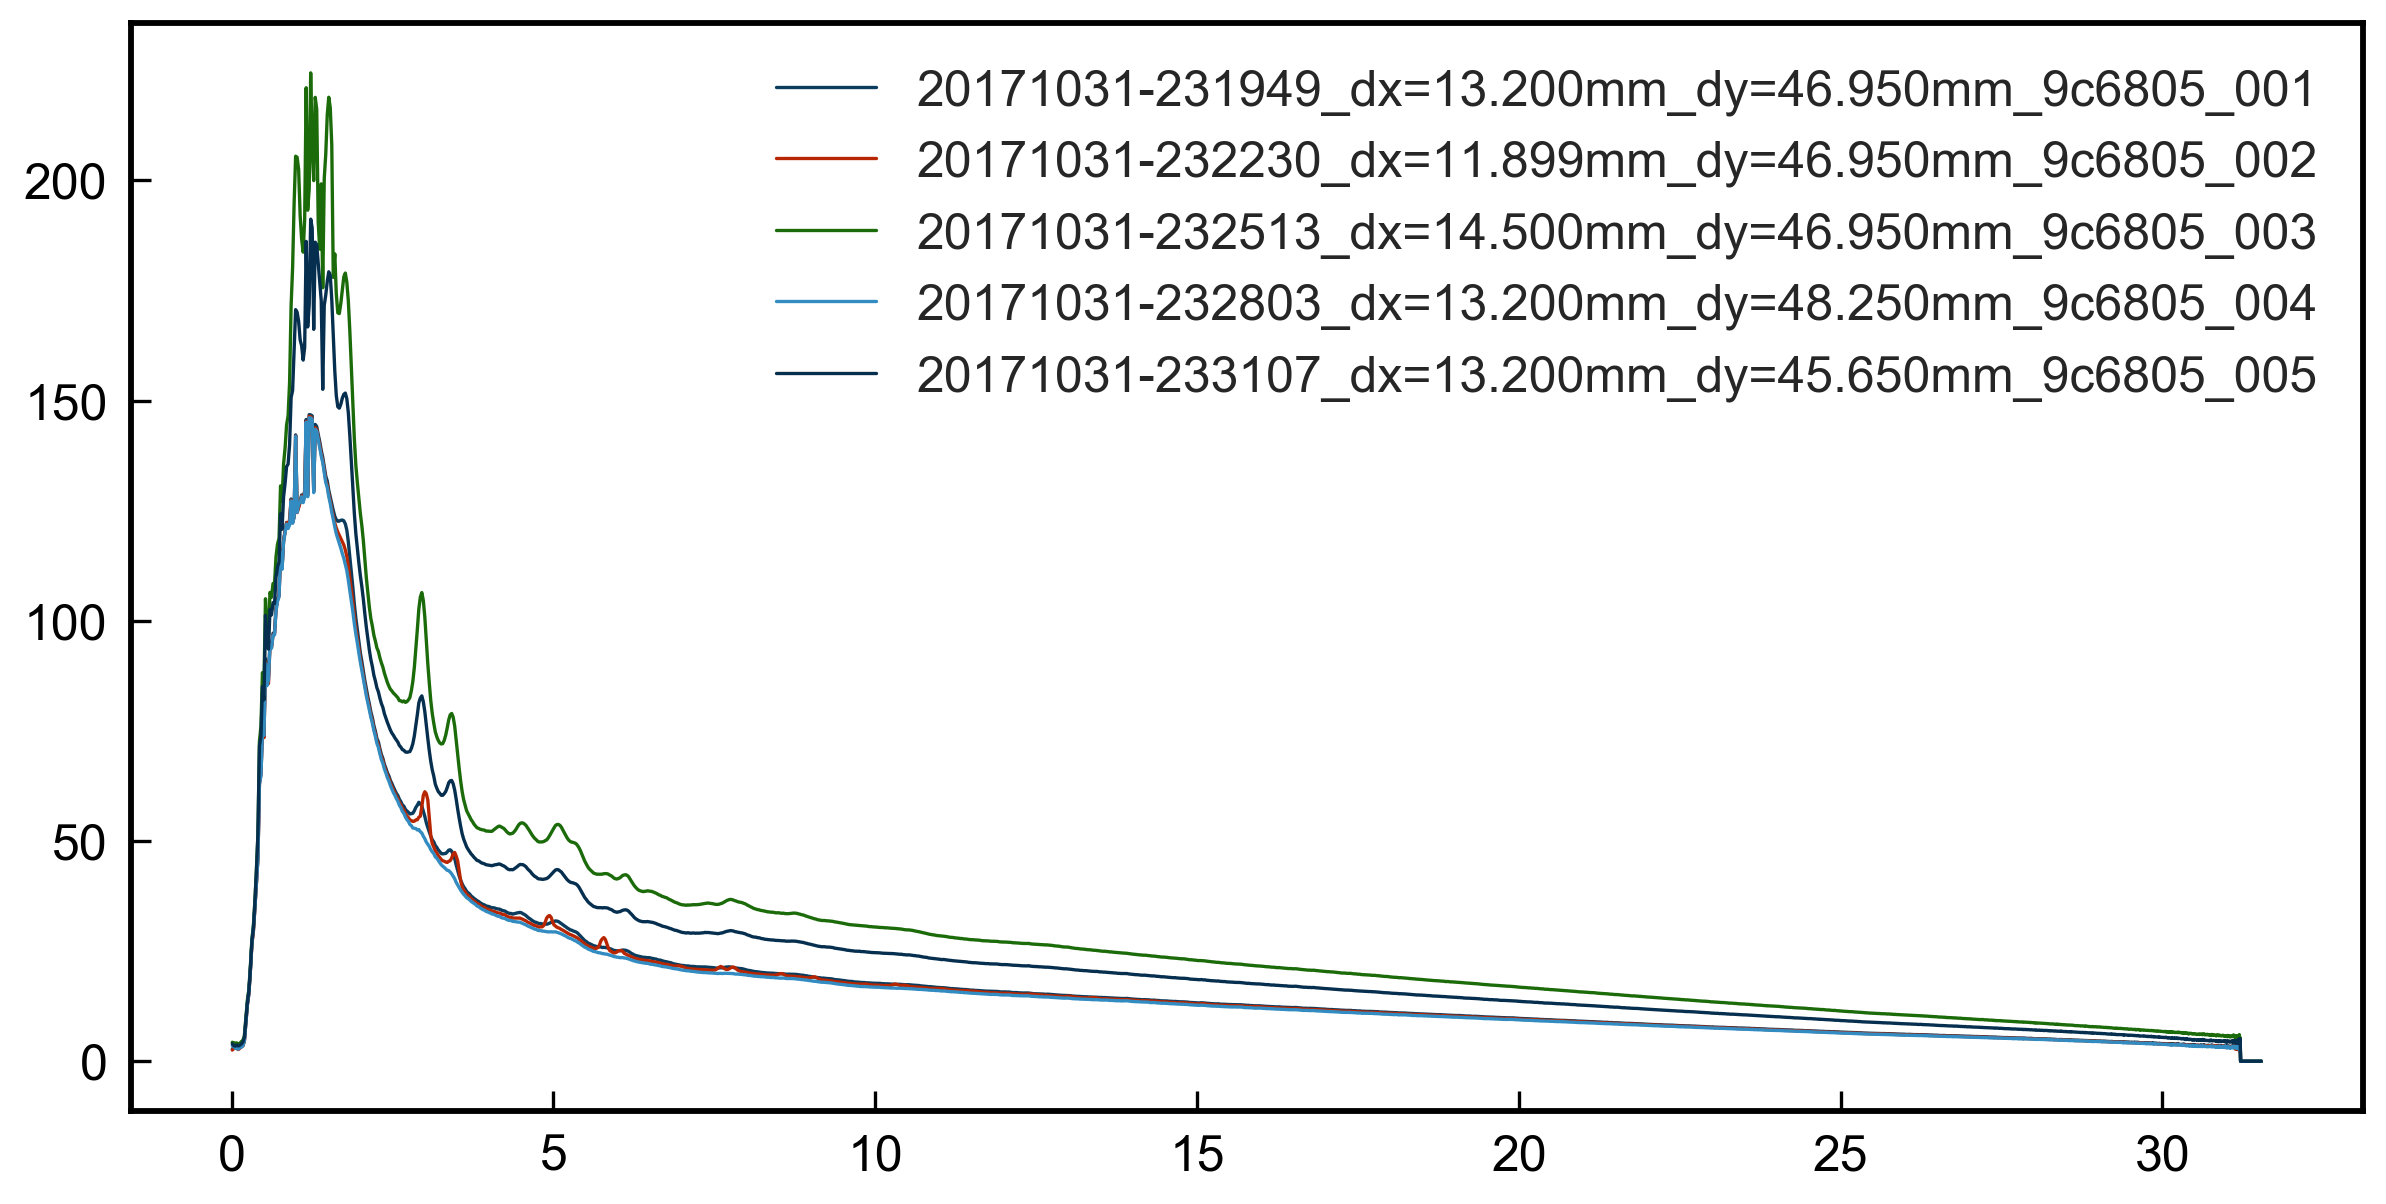

In [38]:

bSeabornStyle(ticks=True, cycle='simon2', f_scale=1)
fig, ((ax1)) = plt.subplots(1, 1, figsize=[12,6])#,gridspec_kw = {'height_ratios':[2, 1]})

#q_bgr,iq_bgr = np.genfromtxt('./automasking_loop_CdSe/pyfai_int/20171031-182338_dx=-13.800mm_dy=19.950mm_cb0d83_001.chi',skip_header=8).T # transpose 
#ax1.plot(q_bgr,iq_bgr,label='bgr',color = 'r',lw=1)#,marker='o')

for d in event_list:
    if d['x']>7 and d['x']<16 and d['y']>41 and d['y']<50:
        ax1.plot(d['q'], d['I'],label=d['basename'],lw=1)

        
#4.2	28.95
#13.2	28.95
#-22.8	37.95
ax1.legend()

In [24]:
# pprint(event_list)

### Use the data in the database to make PDFs

In [39]:
for d in event_list:
    r,gr = make_PDF(d['basename'],d['q'],d['I_sub'],savedir_gr,d['composition'])
    d['r'] = r
    d['gr'] = gr

### make a pickle dump here, then reload the pickle

no need to redo the above every time before the fitting

## Save output

In [35]:
with open(sample_directory+sample_name, 'wb') as fp:
    pickle.dump(event_list, fp)

### Now reload the pickle, if saved from previously

In [12]:
with open(sample_directory+'pickles/'+sample_name, 'r') as fp:
    event_list = pickle.load(fp)

## Perform fitting

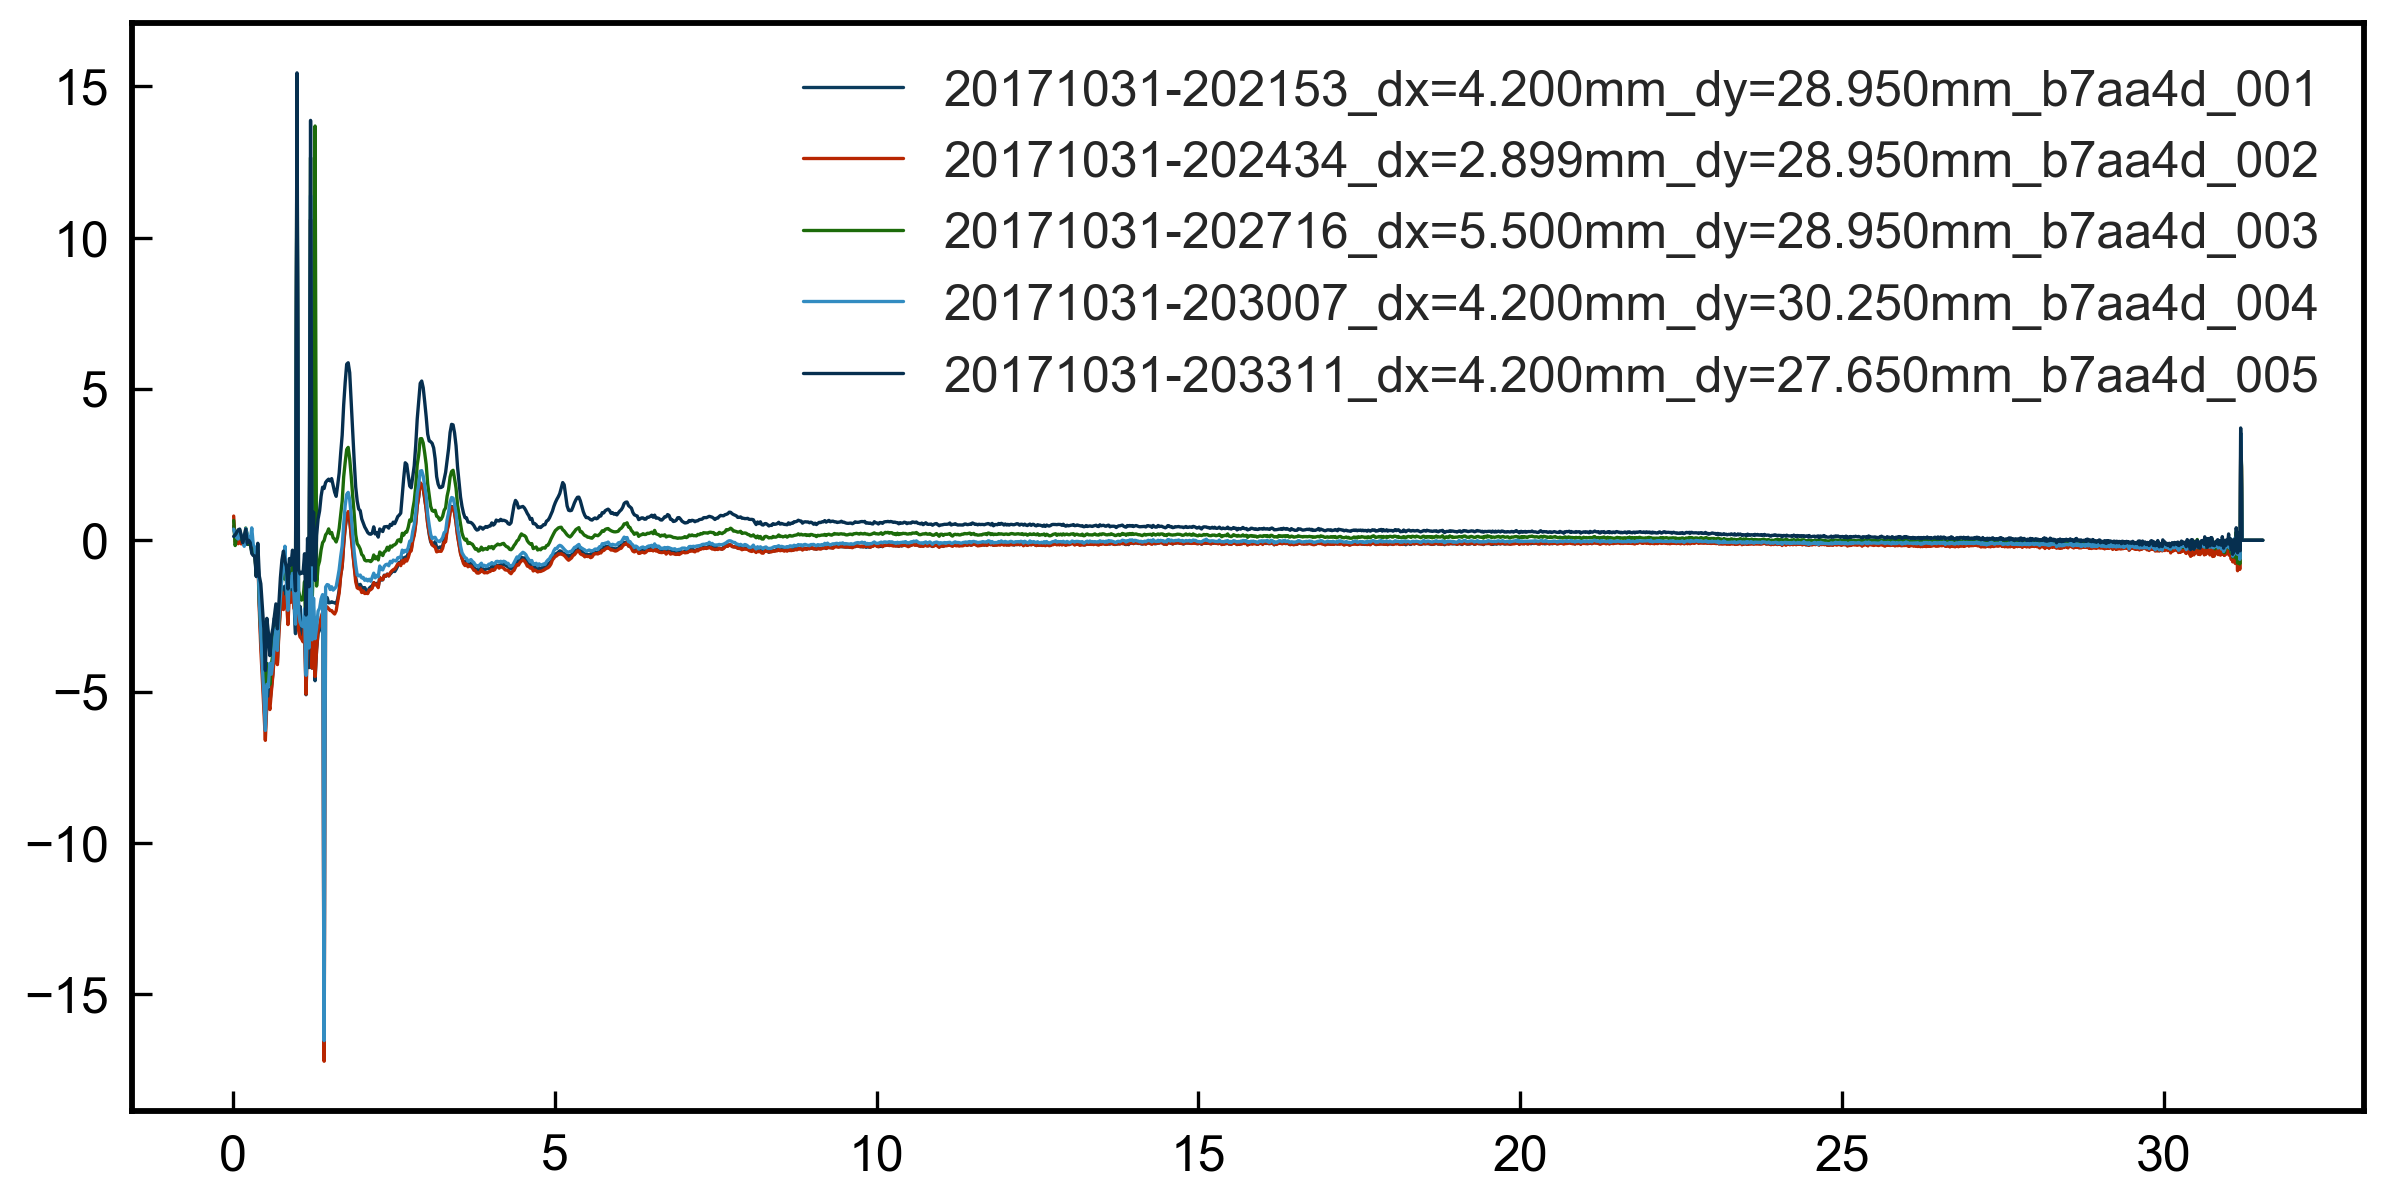

In [41]:
center_x = 4.2
center_y = 28.95
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1)
fig, ((ax1)) = plt.subplots(1, 1, figsize=[12,6])#,gridspec_kw = {'height_ratios':[2, 1]})


for d in event_list:
    if d['x']>(center_x-3) and d['x']<(center_x+3) and d['y']>(center_y-3) and d['y']<(center_y+3):
        ax1.plot(d['q'], d['I_sub'],label=d['basename'],lw=1)

        
#4.2	28.95
#13.2	28.95
#-22.8	37.95
ax1.legend()

In [43]:
for d in event_list:
    if d['x']>(center_x-3) and d['x']<(center_x+3) and d['y']>(center_y-3) and d['y']<(center_y+3):
        print(d['basename'])
        fitCdSe(d['basename'])

20171031-202153_dx=4.200mm_dy=28.950mm_b7aa4d_001


ImportError: No module named 'diffpy.Structure'

In [143]:
## Binary alloy
from diffpy.Structure import Structure

stru1 = Structure(filename=sample_directory+"PtRuComb_mod.cif")

for d in event_list:
    # Give fit identifier here

    basename = d['basename']

    folders = ['resPCA', 'struPCA', 'fitPCA', 'figPCA']
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Make the data and the recipe
    print basename
    data = savedir_gr+basename+'.gr'
    
    # Make the recipe
    recipe = arrayBinaryFCC(stru1, data)
    recipe.clearFitHooks()

    from scipy.optimize import leastsq

    recipe.fix("all")
    
    recipe.free("lat")
    leastsq(recipe.residual, recipe.values)

    recipe.free("scale")
    leastsq(recipe.residual, recipe.values)

    recipe.fix("lat","scale")

    recipe.free("adp")
    leastsq(recipe.residual, recipe.values)

    recipe.free("d2")
    leastsq(recipe.residual, recipe.values)

    recipe.free("all")
    leastsq(recipe.residual, recipe.values)

    # specify the dirs we made earlier 

    resdir = "./resPCA/"
    fitdir = "./fitPCA/"
    strudir = "./struPCA/"
    figdir = "./figPCA/"

    # Save structures
    stru1.write(strudir + basename + ".stru", "pdffit")

    profile = recipe.crystal.profile

    profile.savetxt(fitdir + basename + ".fit")

    # Generate and print the FitResults
    res = FitResults(recipe)
    #res.printResults()

    header = "crystal_HF.\n"
    res.saveResults(resdir + basename + ".res", header=header)

#     plotResults(recipe, figdir+basename)

#         print recipe.names
#         print recipe.values
    print 'rw = ',res.rw
    d['rw'] = res.rw
    d['psize'] = recipe.values[0]
    d['s0'] = recipe.values[1]
    d['lattice constant'] = recipe.values[2]
    d['Pt_U1'] = recipe.values[3]
    d['Ru_U1'] = recipe.values[4]
    d['delta2_crystal1'] = recipe.values[5]
    d['r_fit'] = recipe.crystal.profile.x
    d['g'] = recipe.crystal.profile.y
    d['gcalc'] = recipe.crystal.profile.ycalc
    
with open(sample_directory+sample_name+"w_fit", 'wb') as fp:
    pickle.dump(event_list, fp)
    
print '######## DONE ########'

PtRu_fc_used_00001


/Users/Anton/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 400.
  warnings.warn(errors[info][0], RuntimeWarning)


rw =  1.0
PtRu_fc_used_00002
rw =  1.0
PtRu_fc_used_00003
rw =  1.0
PtRu_fc_used_00004
rw =  1.0
PtRu_fc_used_00005
rw =  1.0
PtRu_fc_used_00006
rw =  1.0
PtRu_fc_used_00007
rw =  1.0
PtRu_fc_used_00008
rw =  1.0
PtRu_fc_used_00009
rw =  1.0
PtRu_fc_used_00010
rw =  1.0
PtRu_fc_used_00011
rw =  1.0
PtRu_fc_used_00012
rw =  1.0
PtRu_fc_used_00013
rw =  1.0
PtRu_fc_used_00014
rw =  1.0
PtRu_fc_used_00015
rw =  1.0
PtRu_fc_used_00016
rw =  1.0
PtRu_fc_used_00017
rw =  1.0
PtRu_fc_used_00018
rw =  1.0
PtRu_fc_used_00019
rw =  1.0
PtRu_fc_used_00020
rw =  0.859713523781
PtRu_fc_used_00021
rw =  1.0
PtRu_fc_used_00022
rw =  1.0
PtRu_fc_used_00023
rw =  0.859025632856
PtRu_fc_used_00024
rw =  1.0
PtRu_fc_used_00025
rw =  1.0
PtRu_fc_used_00026
rw =  1.0
PtRu_fc_used_00027
rw =  0.172140031805
PtRu_fc_used_00028
rw =  0.17039831696
PtRu_fc_used_00029
rw =  0.167703304167
PtRu_fc_used_00030
rw =  0.164351050035
PtRu_fc_used_00031
rw =  0.163659732659
PtRu_fc_used_00032
rw =  0.161422659827
PtRu

In [85]:
# ## Single element
# from diffpy.Structure import Structure

# stru1 = Structure(filename="Pt_41525.cif")
# for x in event_list if x['composition'] == 'PtPb'
# for d in event_list[0:25]:
#     # Give fit identifier here

#     basename = d['basename']

#     folders = ['./processed_data/resPCA',
#                './processed_data/struPCA',
#                './processed_data/fitPCA',
#                './processed_data/figPCA']
#     for folder in folders:
#         if not os.path.exists(folder):
#             os.makedirs(folder)

#     # Make the data and the recipe
#     print basename
#     data = savedir_gr+basename+'.gr'

#     # print basename
#     # Make the recipe



#     recipe = arrayFCC(stru1, data,3.6)
#     recipe.clearFitHooks()

#     from scipy.optimize import leastsq

#     recipe.fix("all")

#     recipe.free("lat")
#     leastsq(recipe.residual, recipe.values)

#     recipe.free("scale")
#     leastsq(recipe.residual, recipe.values)

#     recipe.fix("lat","scale")

#     recipe.free("adp")
#     leastsq(recipe.residual, recipe.values)

#     recipe.free("d2")
#     leastsq(recipe.residual, recipe.values)

#     # recipe.free("ico_inst")
#     # leastsq(recipe.residual, recipe.values)

#     recipe.free("all")
#     leastsq(recipe.residual, recipe.values)

#     # specify the dirs we made earlier 

#     resdir = "./processed_data/resPCA/"
#     fitdir = "./processed_data/fitPCA/"
#     strudir = "./processed_data/struPCA/"
#     figdir = "./processed_data/figPCA/"

#     # Save structures
#     stru1.write(strudir + basename + ".stru", "pdffit")

#     profile = recipe.crystal.profile

#     profile.savetxt(fitdir + basename + ".fit")

#     # Generate and print the FitResults
#     res = FitResults(recipe)
#     #res.printResults()

#     header = "crystal_HF.\n"
#     res.saveResults(resdir + basename + ".res", header=header)

# #     plotResults(recipe, figdir+basename)

# #         print recipe.names
# #         print recipe.values
#     print 'rw = ',res.rw
#     d['rw'] = res.rw
#     d['psize'] = recipe.values[0]
#     d['s0'] = recipe.values[1]
#     d['lattice constant'] = recipe.values[2]
#     d['Pt_U1'] = recipe.values[3]
#     #d['Cu_U1'] = recipe.values[4] #the length of recipe.values depends on the number of parameters
#     d['delta2_crystal1'] = recipe.values[4]
# #     d['delta2_crystal1'] = recipe.values[5]
#     d['r_fit'] = recipe.crystal.profile.x
#     d['g'] = recipe.crystal.profile.y
#     d['gcalc'] = recipe.crystal.profile.ycalc
    
# with open('small_array_refined', 'wb') as fp:
#     pickle.dump(event_list, fp)
    
# print '######## DONE 3 of 3 ########'

In [31]:
if res.rw > 0.5:
    print 'hi'

hi


In [87]:
with open('../PtRu_march2017/PtRu_fresh_cellw_fit', 'r') as fp:
    event_list = pickle.load(fp)

In [175]:
for d in event_list:
#     if d['I_sum'] < 0:
#         d['I_sum'] = 0.1
#     d['I_sum'] = np.log(d['I_sum'])
    d['roundx'] = np.around(d['x'], decimals=2)
    d['roundy'] = np.around(d['y'], decimals=2)
    d['integrated_intensity'] = np.sum(d['I_sub'][50:900])
    
# for d in event_list:
#     if d['psize'] > 1000:
#         d['psize'] = 1000
#     if d['rw'] > 0.6:
#         d['psize'] = 0
#         d['lattice constant'] = 3.97

        

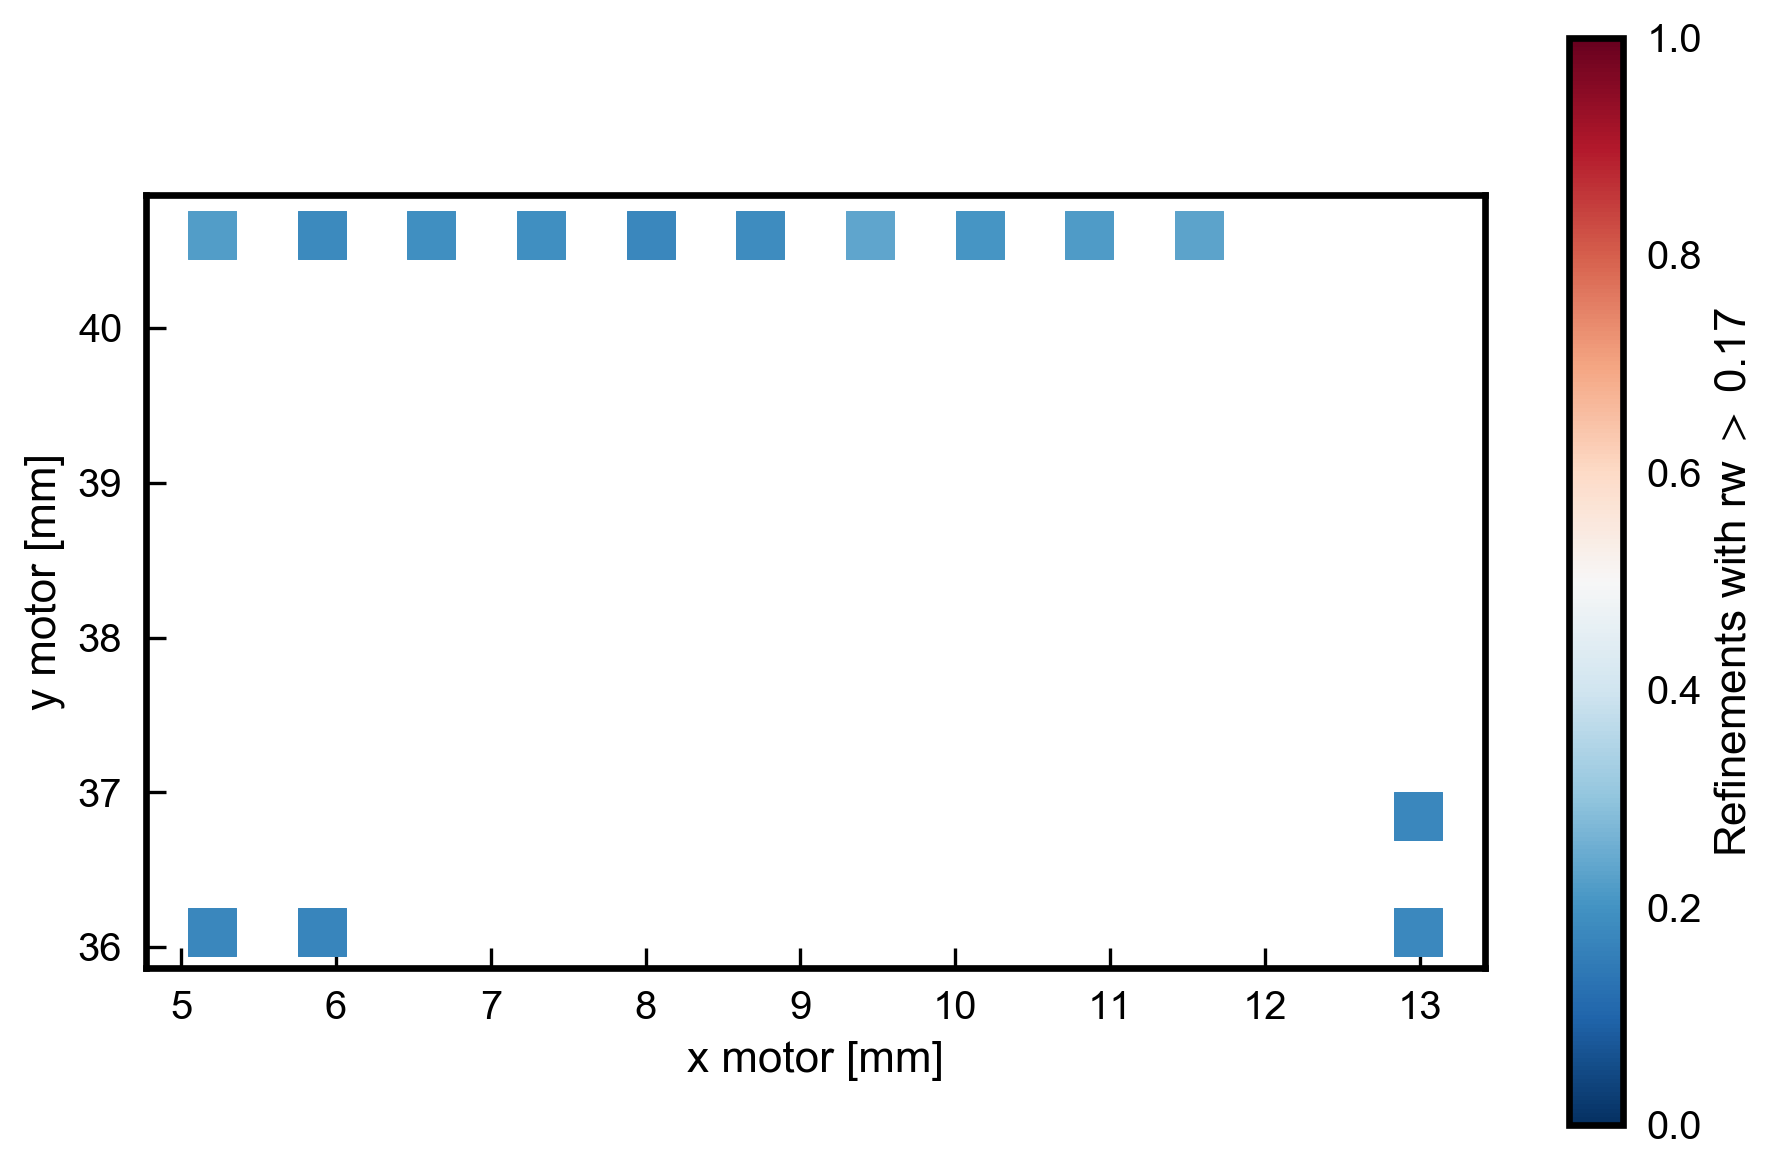

In [263]:
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)
for d in event_list:
    if d['rw']>0.17:
        if d['rw']<0.25:
            plt.scatter(d['x'], d['y'], c=d['rw'],cmap = 'RdBu_r', vmin = 0, vmax = 1, marker = 's', s= 200)
    
# plt.xlim(5.5,13.5)
# plt.ylim(35.5,39.5)

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')
plt.axes().set_aspect('equal')
plot = plt.colorbar()
plot.set_label('Refinements with rw $>$ 0.17 ')

### starting value test of 4.0

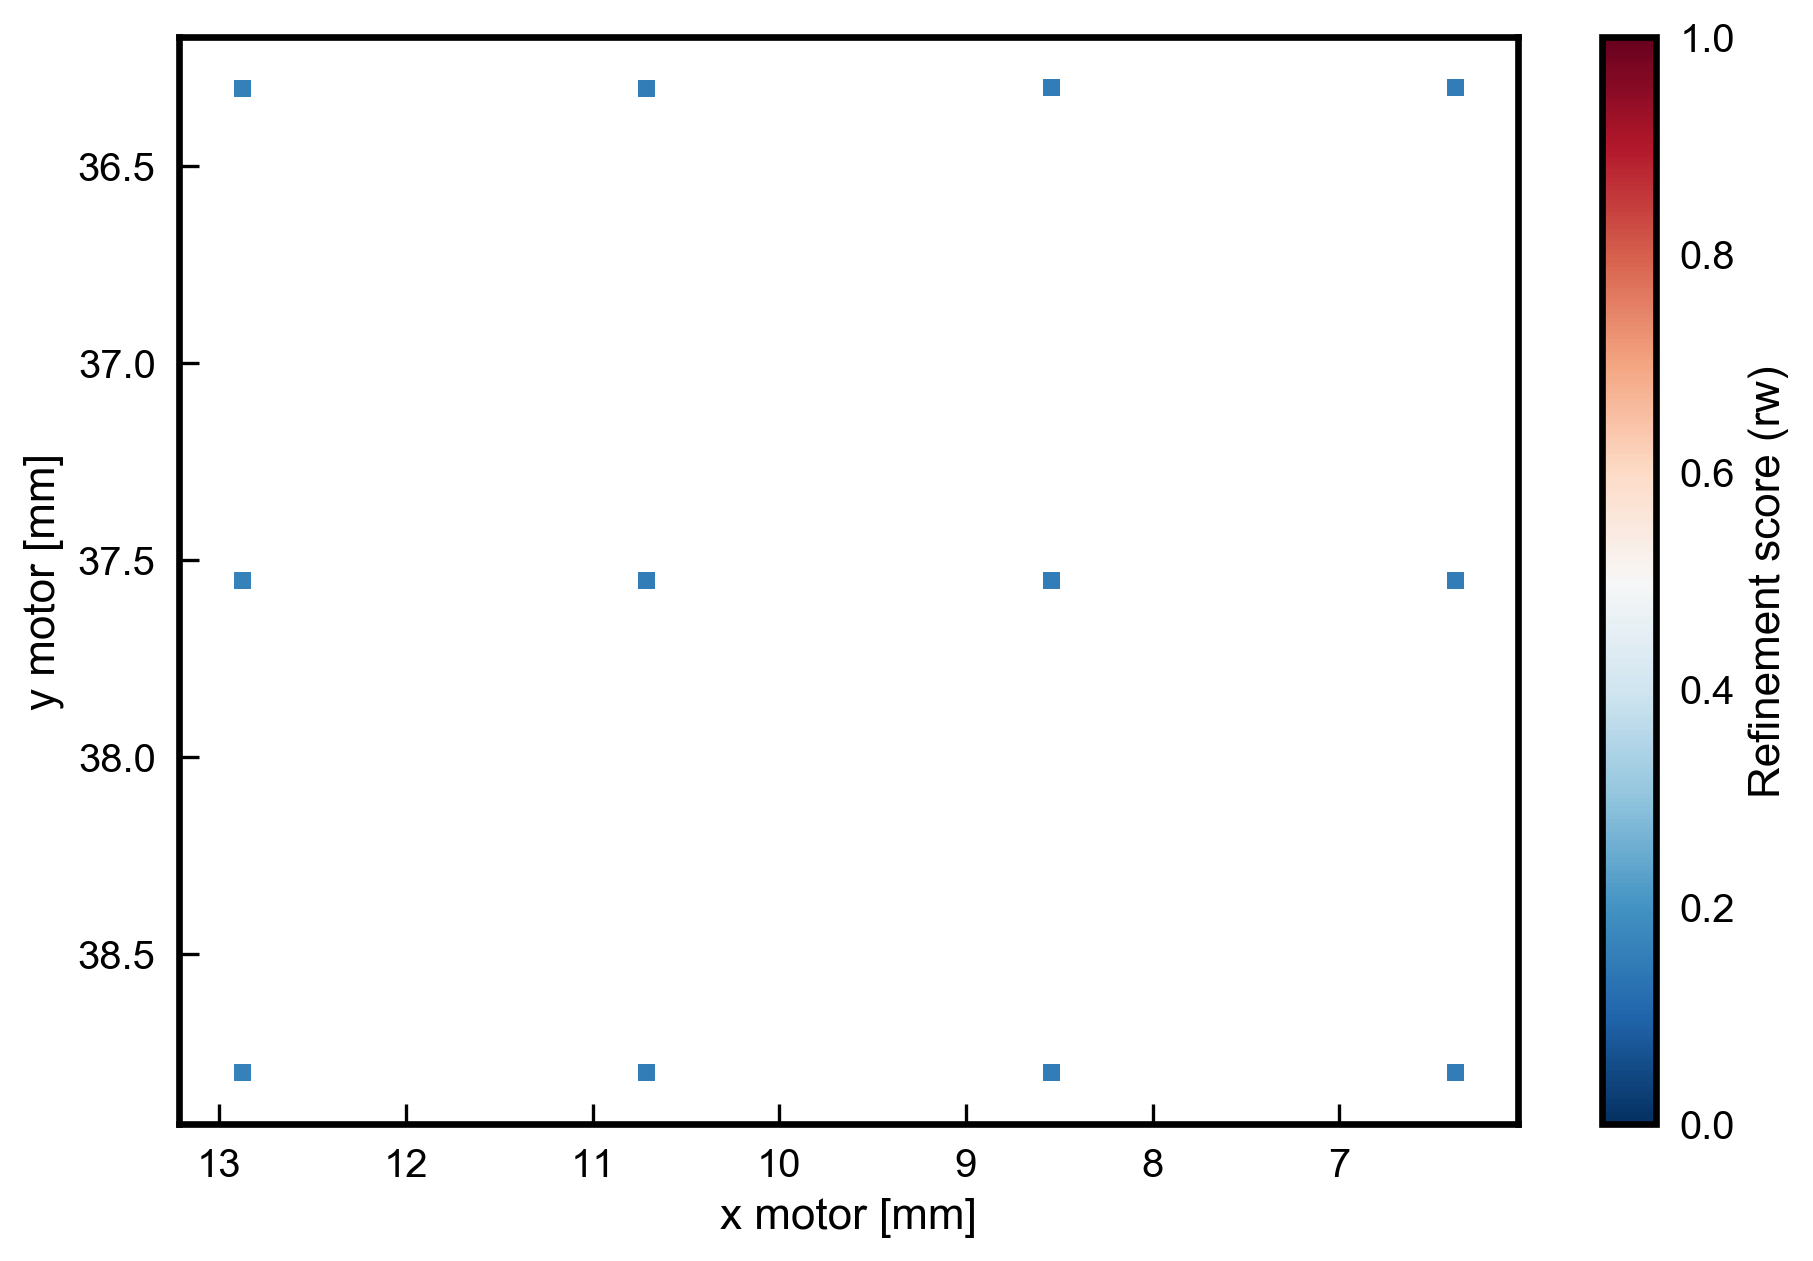

In [101]:
##
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)
for d in event_list:
    plt.scatter(d['x'], d['y'], c=d['rw'],cmap = 'RdBu_r', vmin = 0, vmax = 1, marker = 's')
    
# plt.xlim(24,-26)
# plt.ylim(28,-22)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')

plot = plt.colorbar()
plot.set_label('Refinement score (rw)')

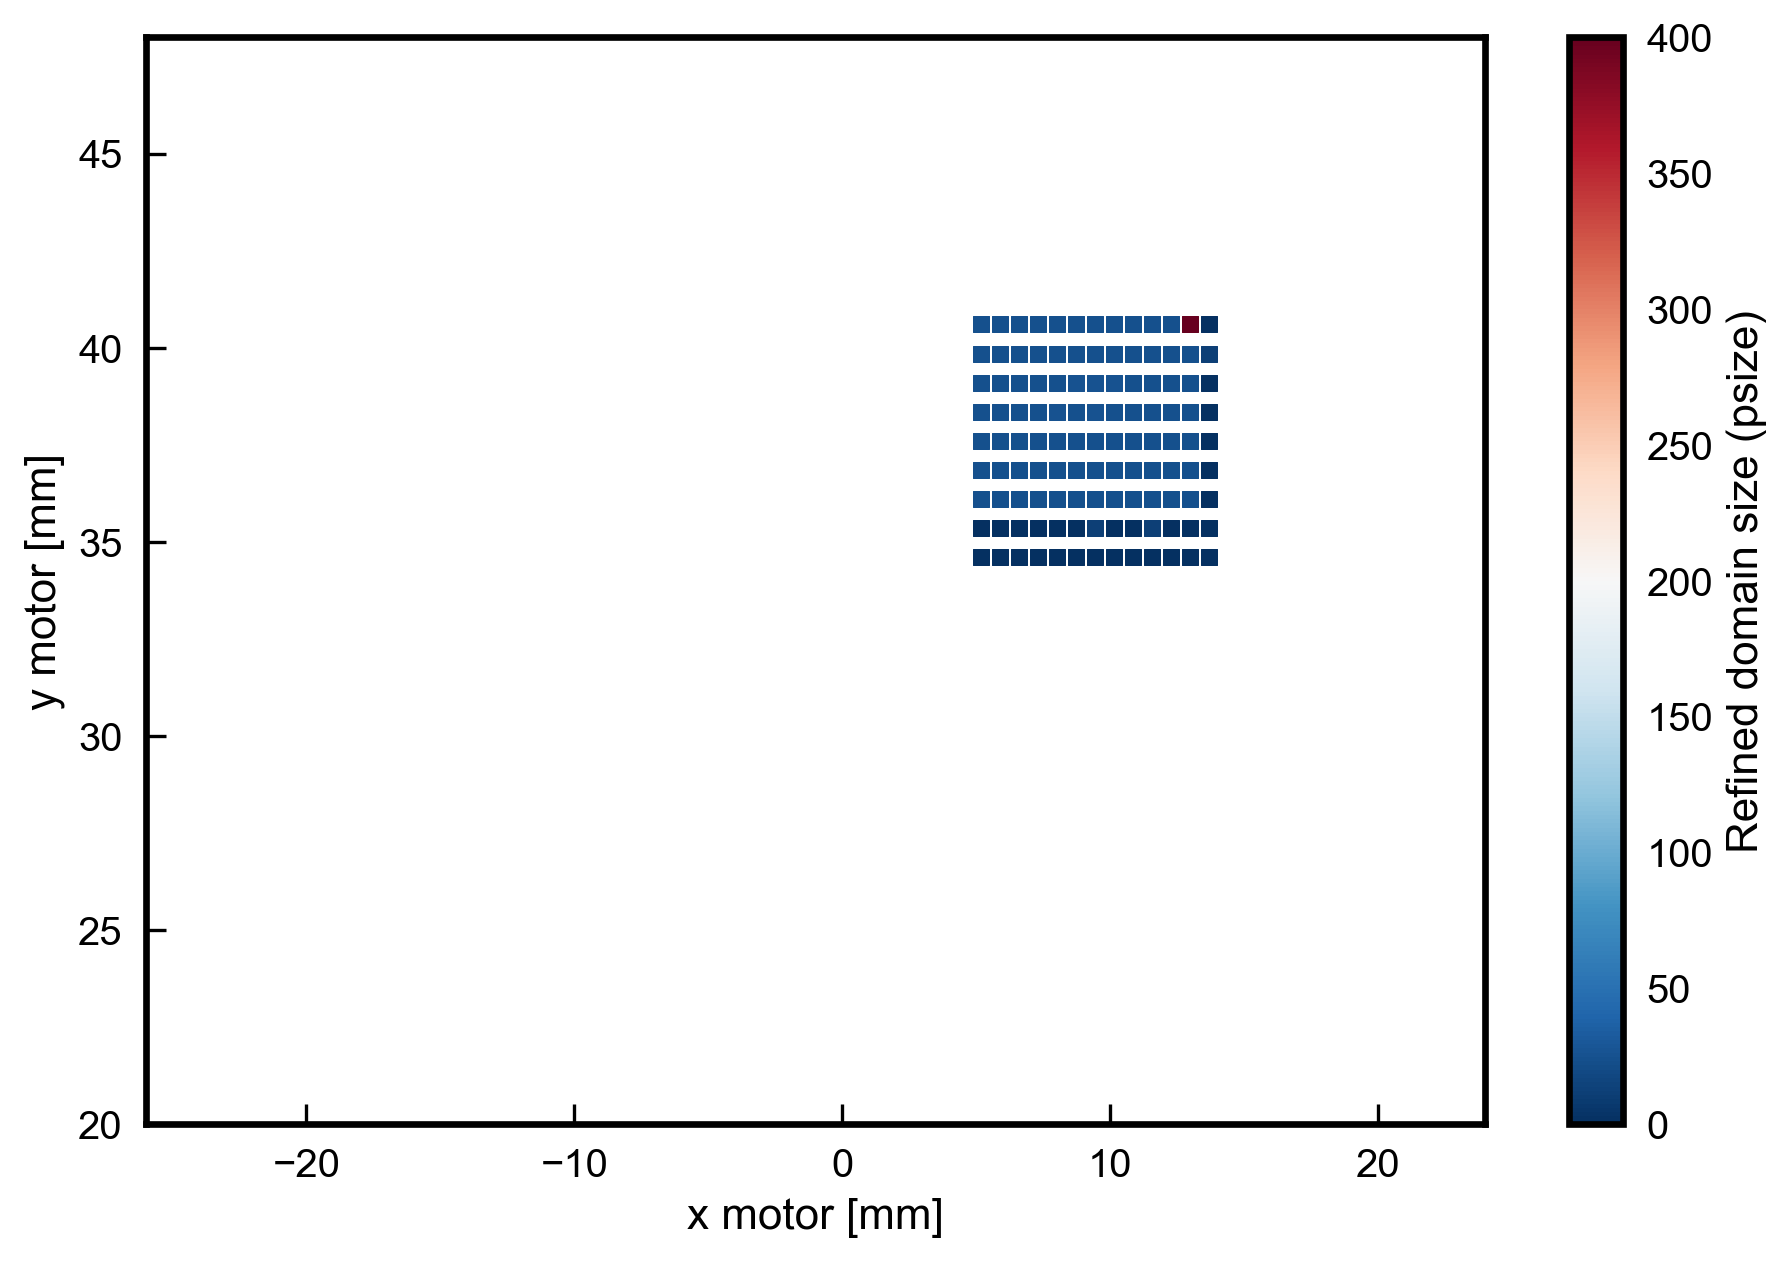

In [198]:
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)
for d in event_list:
    plt.scatter(d['x'], d['y'], c=d['psize'],cmap = 'RdBu_r', vmin = 0, vmax = 400, marker = 's')

plt.xlim(24,-26)
plt.ylim(48,20)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')

plot = plt.colorbar()
plot.set_label('Refined domain size (psize)')

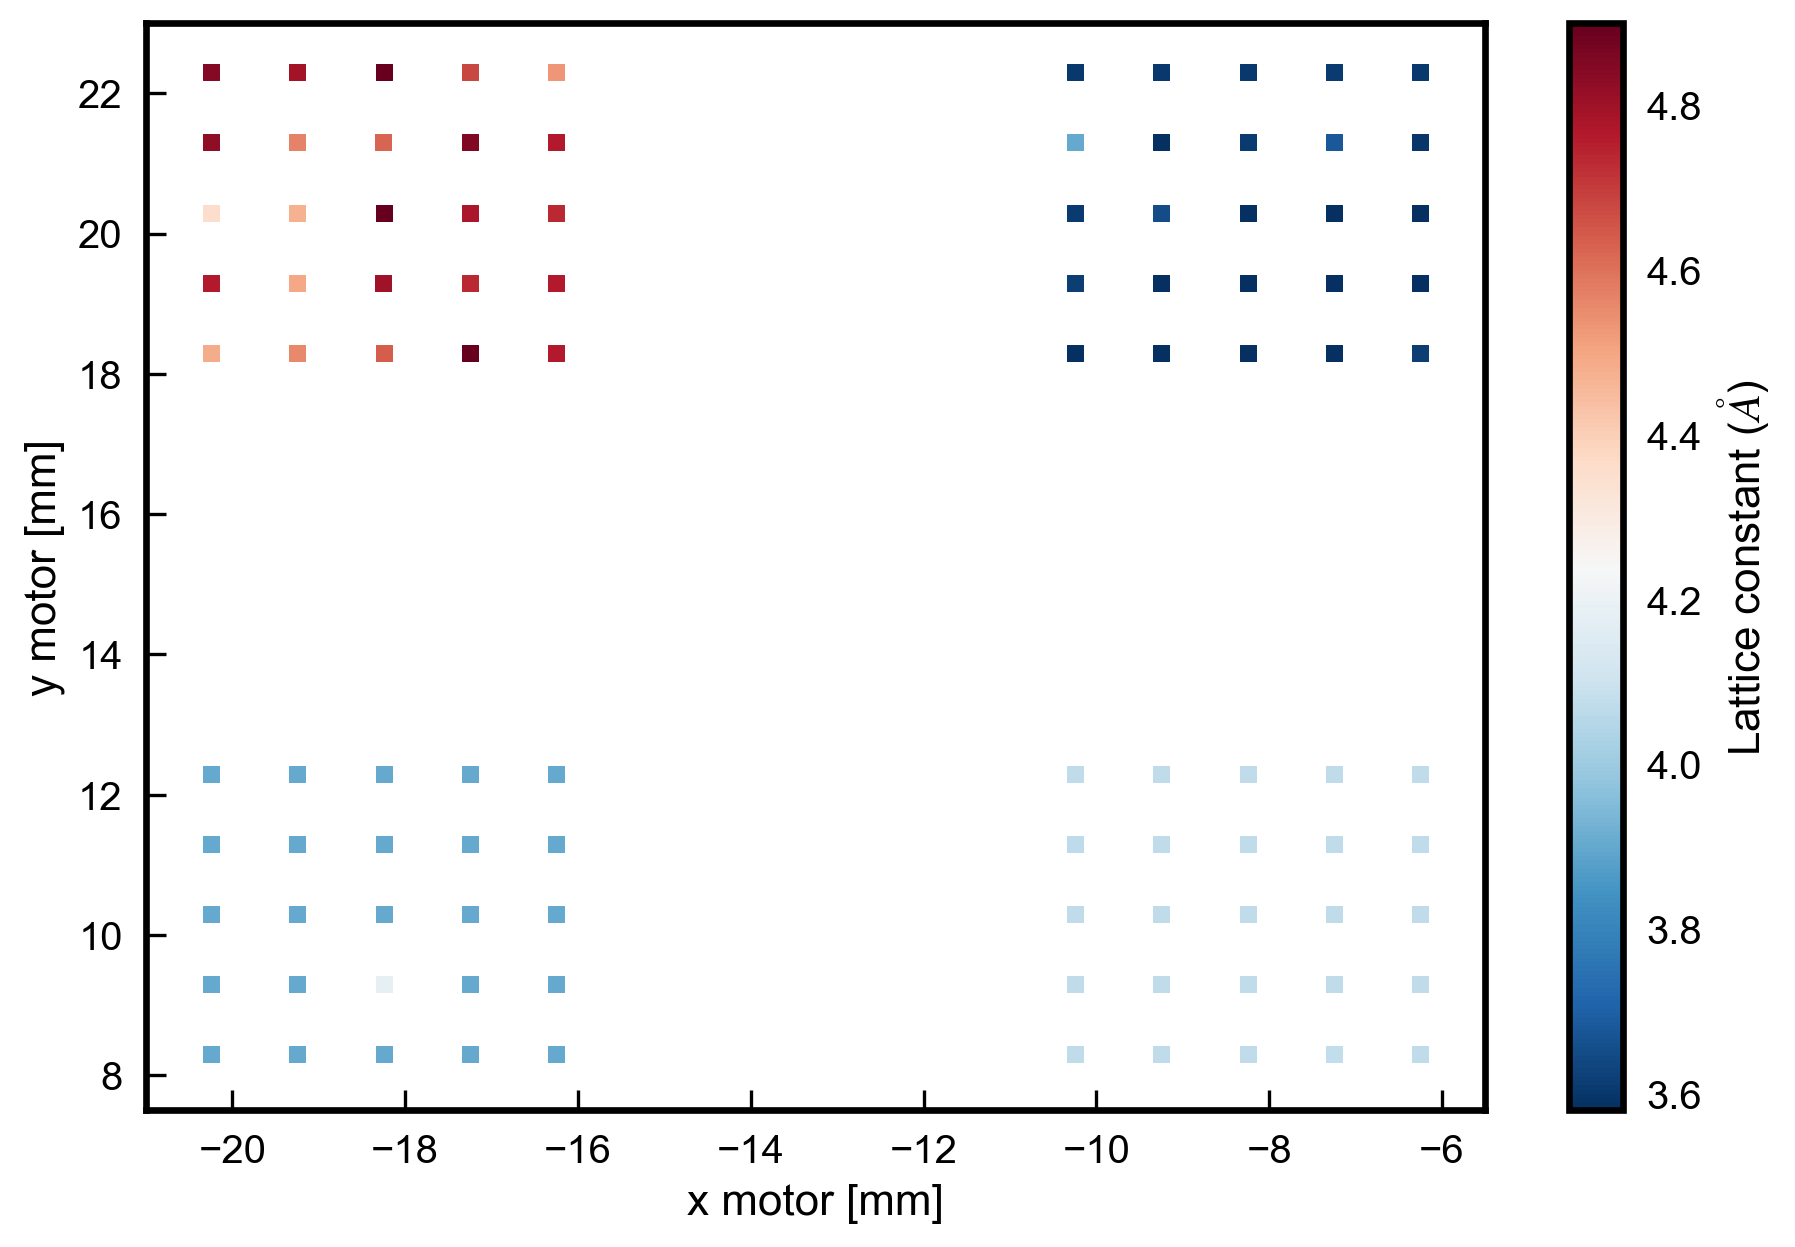

In [15]:
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)
for d in event_list[0:100]:
    plt.scatter(d['x'], d['y'], c=d['lattice constant'],cmap = 'RdBu_r', vmin = 3.58, vmax = 4.9, marker = 's')

plt.xlim(-21,-5.5)
plt.ylim(7.5,23)

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')

plot = plt.colorbar()
plot.set_label('Lattice constant ($\AA$)')

In [176]:
df = pd.DataFrame(event_list)
# df.head()

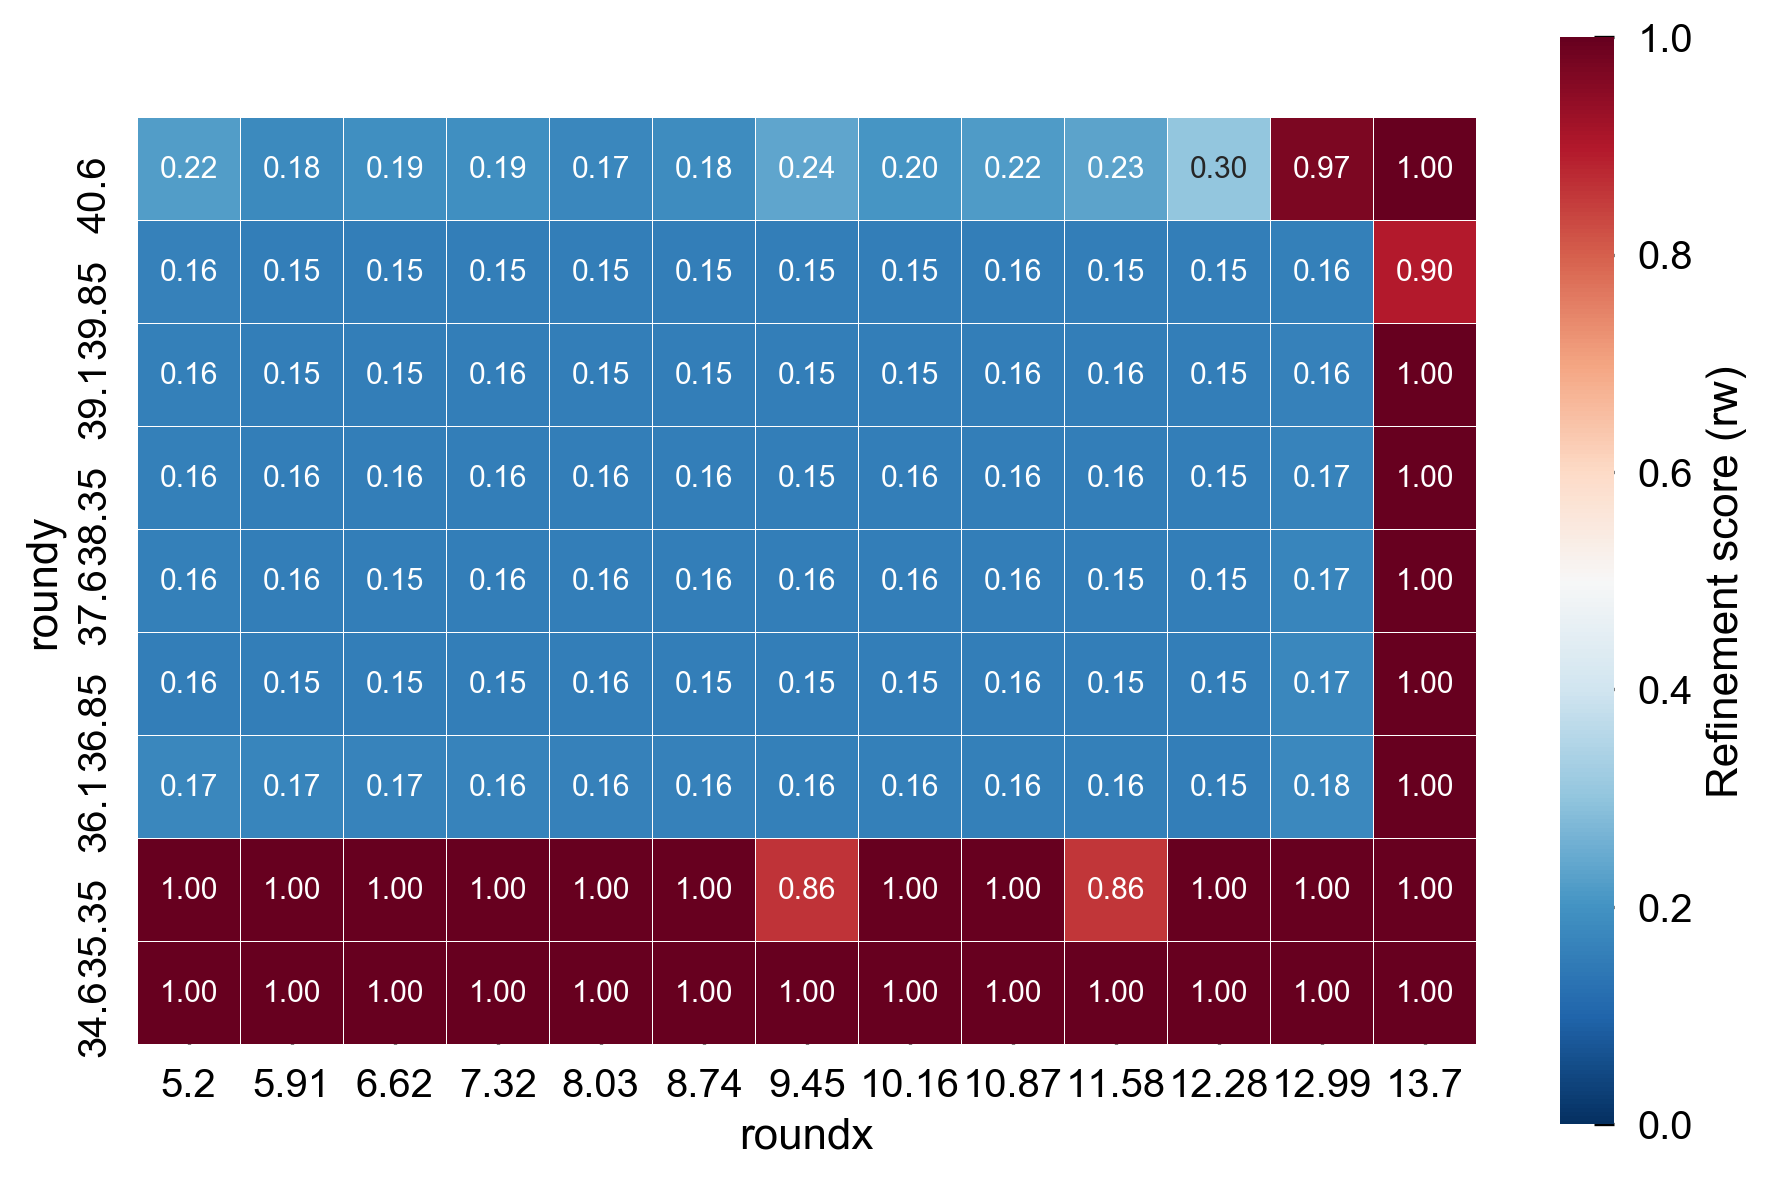

In [151]:
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)

pivot = (df.pivot('roundx','roundy','rw'))

pivot = pd.pivot_table(df,values='rw',index='roundy',columns='roundx')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,vmin = 0, vmax = 1,
            cmap = 'RdBu_r', cbar = True,cbar_kws={'label': 'Refinement score (rw)'});
ax.invert_yaxis()
# # ax.invert_xaxis()
# # ax.invert_yaxis()
# plt.savefig('E075A_phase.pdf',format='pdf')
# sns.heatmap([df.y, df.x], annot=True)

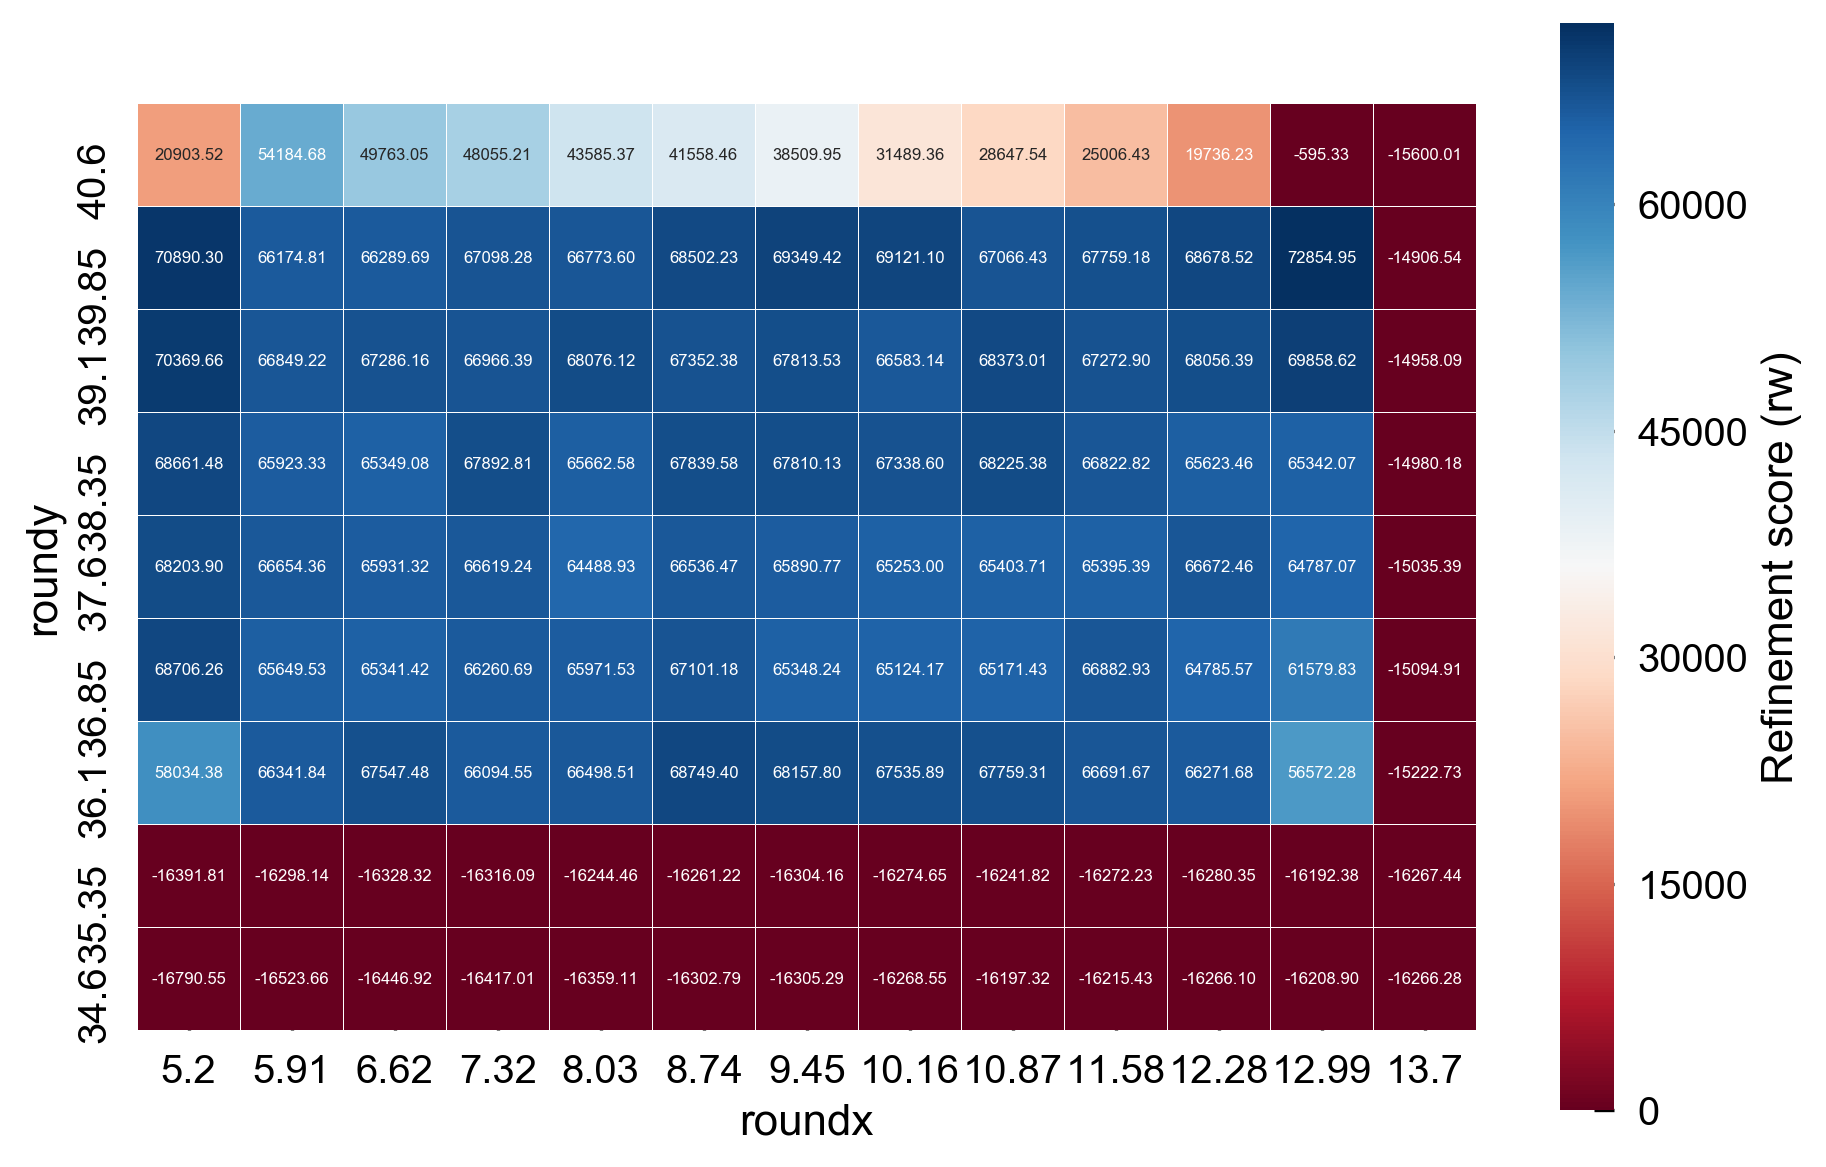

In [267]:
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)

# pivot = (df.pivot('roundx','roundy','rw'))
pivot = (df.pivot('roundx','roundy','integrated_intensity'))

pivot = pd.pivot_table(df,values='integrated_intensity',index='roundy',columns='roundx')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 5}, fmt=".2f", 
            linewidths=0.1, square = True,vmin = 0,vmax = 72000,
            cmap = 'RdBu', cbar = True,cbar_kws={'label': 'Refinement score (rw)'});
ax.invert_yaxis()
# # ax.invert_xaxis()
# # ax.invert_yaxis()
# plt.savefig('E075A_phase.pdf',format='pdf')
# sns.heatmap([df.y, df.x], annot=True)

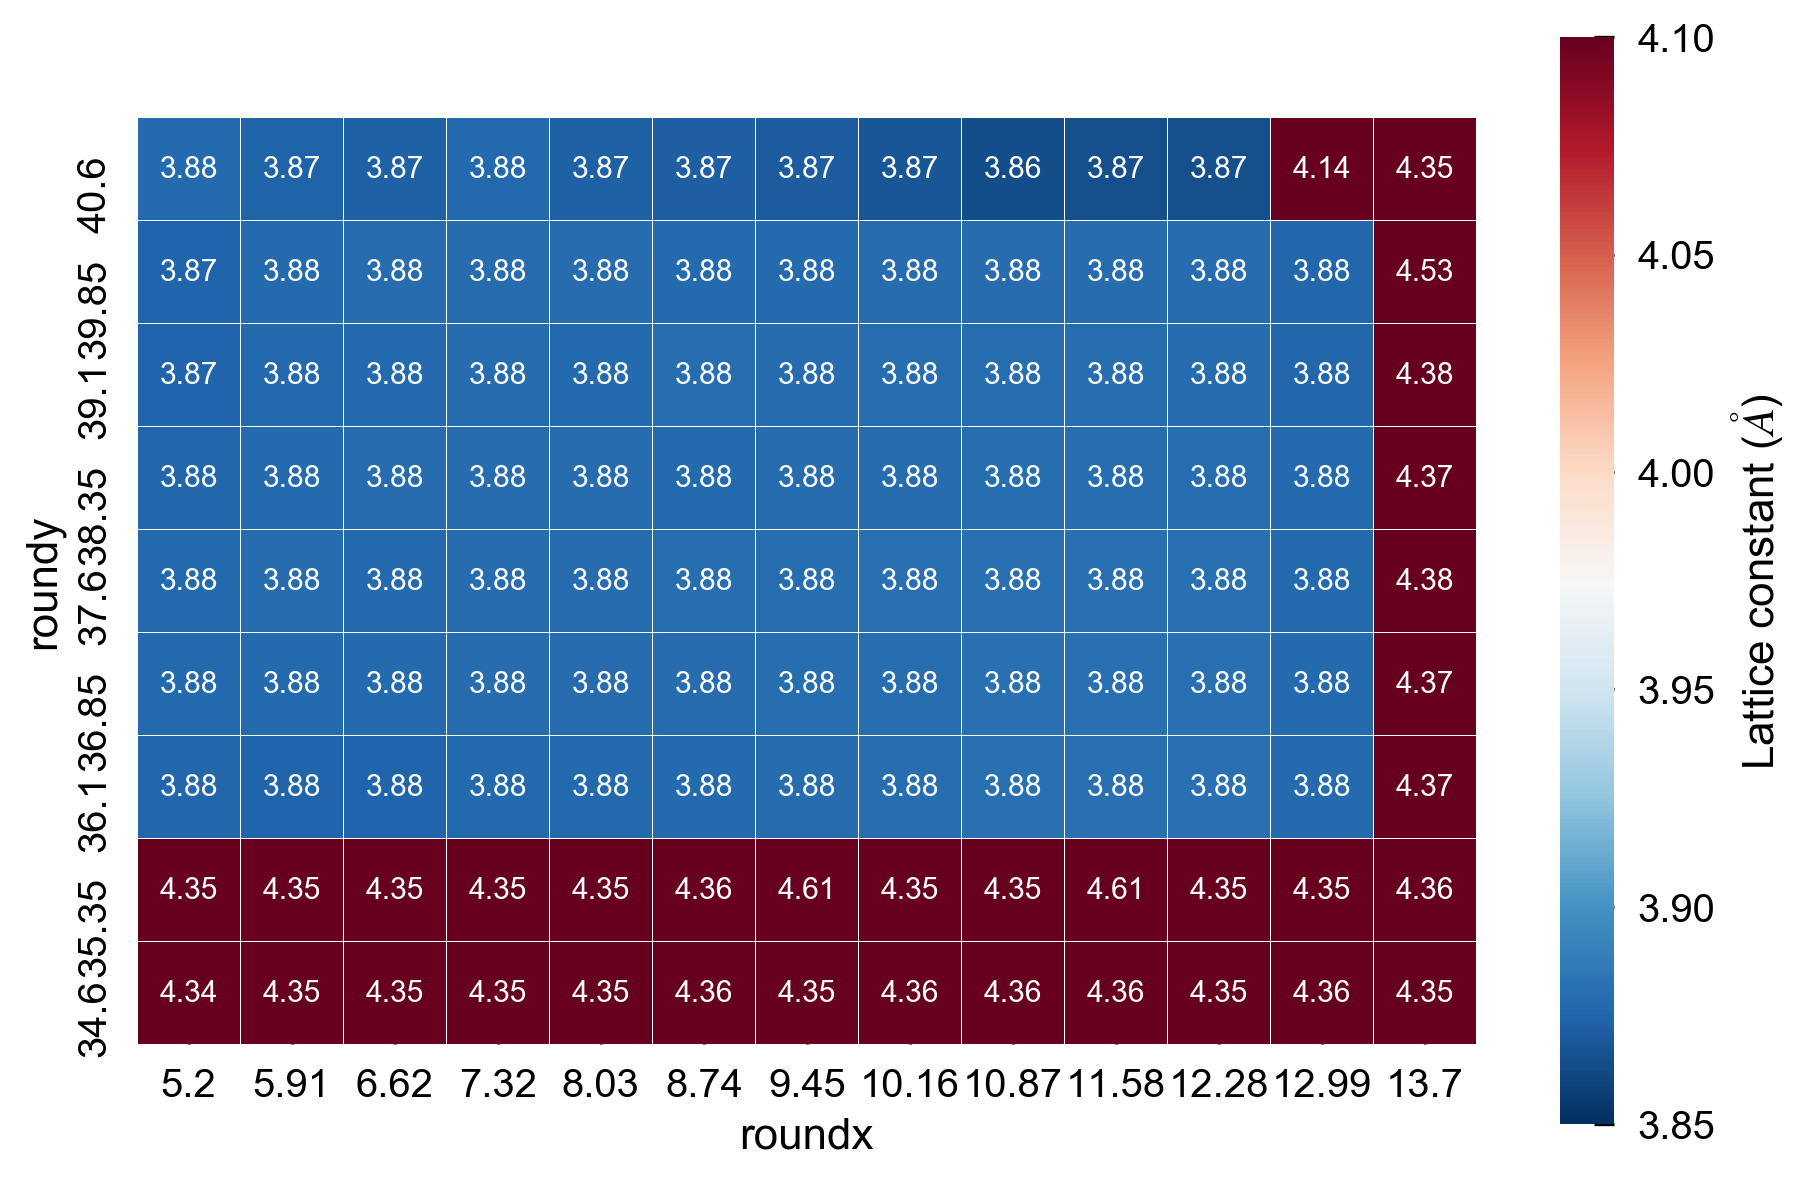

In [153]:
# plt.figure(figsize=(14,6))
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)
grid_heatmap_2 = (df.pivot('roundx','roundy','lattice constant'))

pivot = pd.pivot_table(df,values='lattice constant',index='roundy',columns='roundx')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True, cbar = True,cmap = 'RdBu_r',vmin = 3.85,vmax = 4.1,
                 cbar_kws={'label': 'Lattice constant ($\AA$)'});
ax.invert_yaxis()
# # ax.invert_xaxis()
# # ax.invert_yaxis()
# plt.savefig('E075A_phase.pdf',format='pdf')
# sns.heatmap([df.y, df.x], annot=True)

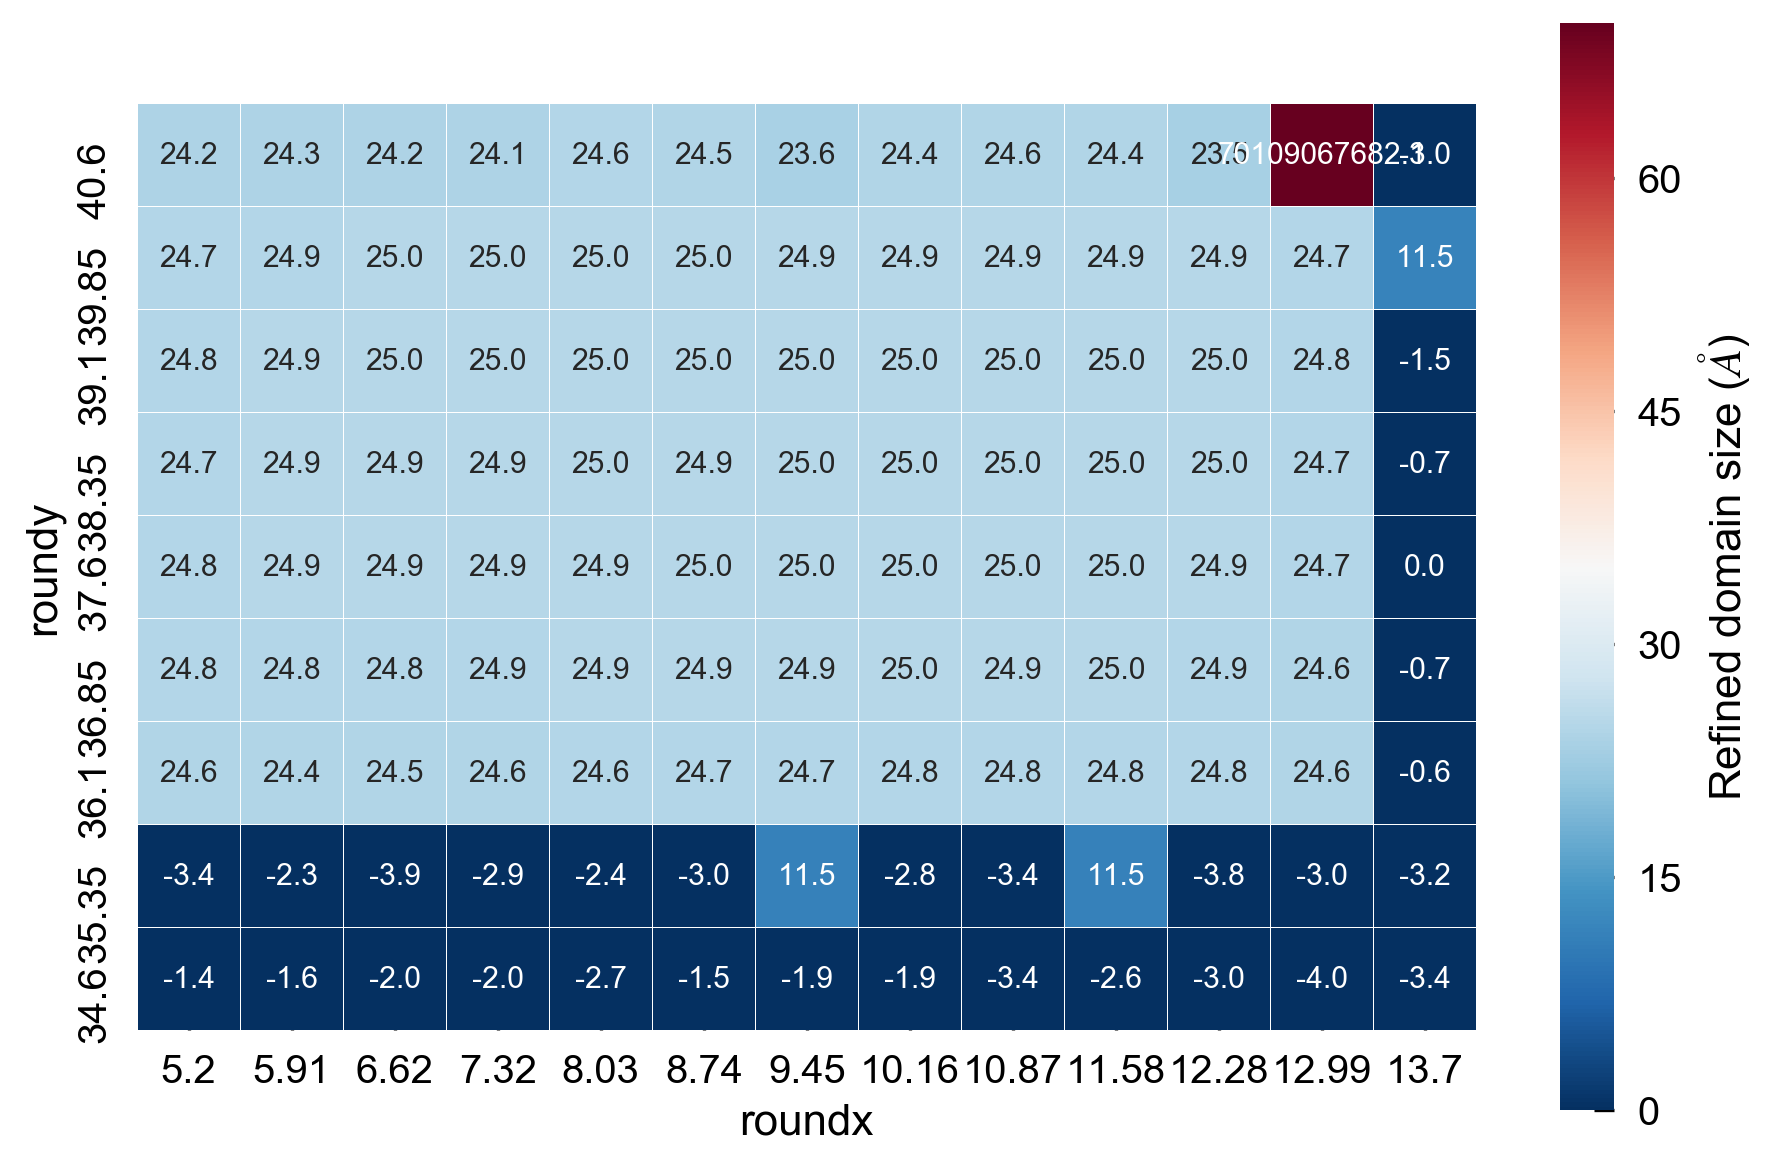

In [154]:
# plt.figure(figsize=(14,6))
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)
grid_heatmap_2 = (df.pivot('roundx','roundy','psize'))

pivot = pd.pivot_table(df,values='psize',index='roundy',columns='roundx')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".1f", 
            linewidths=0.1, square = True, cbar = True,cmap = 'RdBu_r',vmin = 0,vmax = 70,
                cbar_kws={'label': 'Refined domain size ($\AA$)'});
ax.invert_yaxis()
# # ax.invert_xaxis()
# # ax.invert_yaxis()
# plt.savefig('E075A_phase.pdf',format='pdf')
# sns.heatmap([df.y, df.x], annot=True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28
scale =  1.0
Optimization terminated successfully.
         Current function value: 9.081627
         Iterations: 16
         Function evaluations: 32
scale =  0.917999267578
Optimization terminated successfully.
         Current function value: 14.228990
         Iterations: 14
         Function evaluations: 28
scale =  1.01431274414
Optimization terminated successfully.
         Current function value: 11.490917
         Iterations: 15
         Function evaluations: 30
scale =  0.962121582031
Optimization terminated successfully.
         Current function value: 98.749252
         Iterations: 13
         Function evaluations: 26
scale =  1.03626708984
Optimization terminated successfully.
         Current function value: 253.693396
         Iterations: 14
         Function evaluations: 28
scale =  1.08536376953
Optimization terminated successfully.

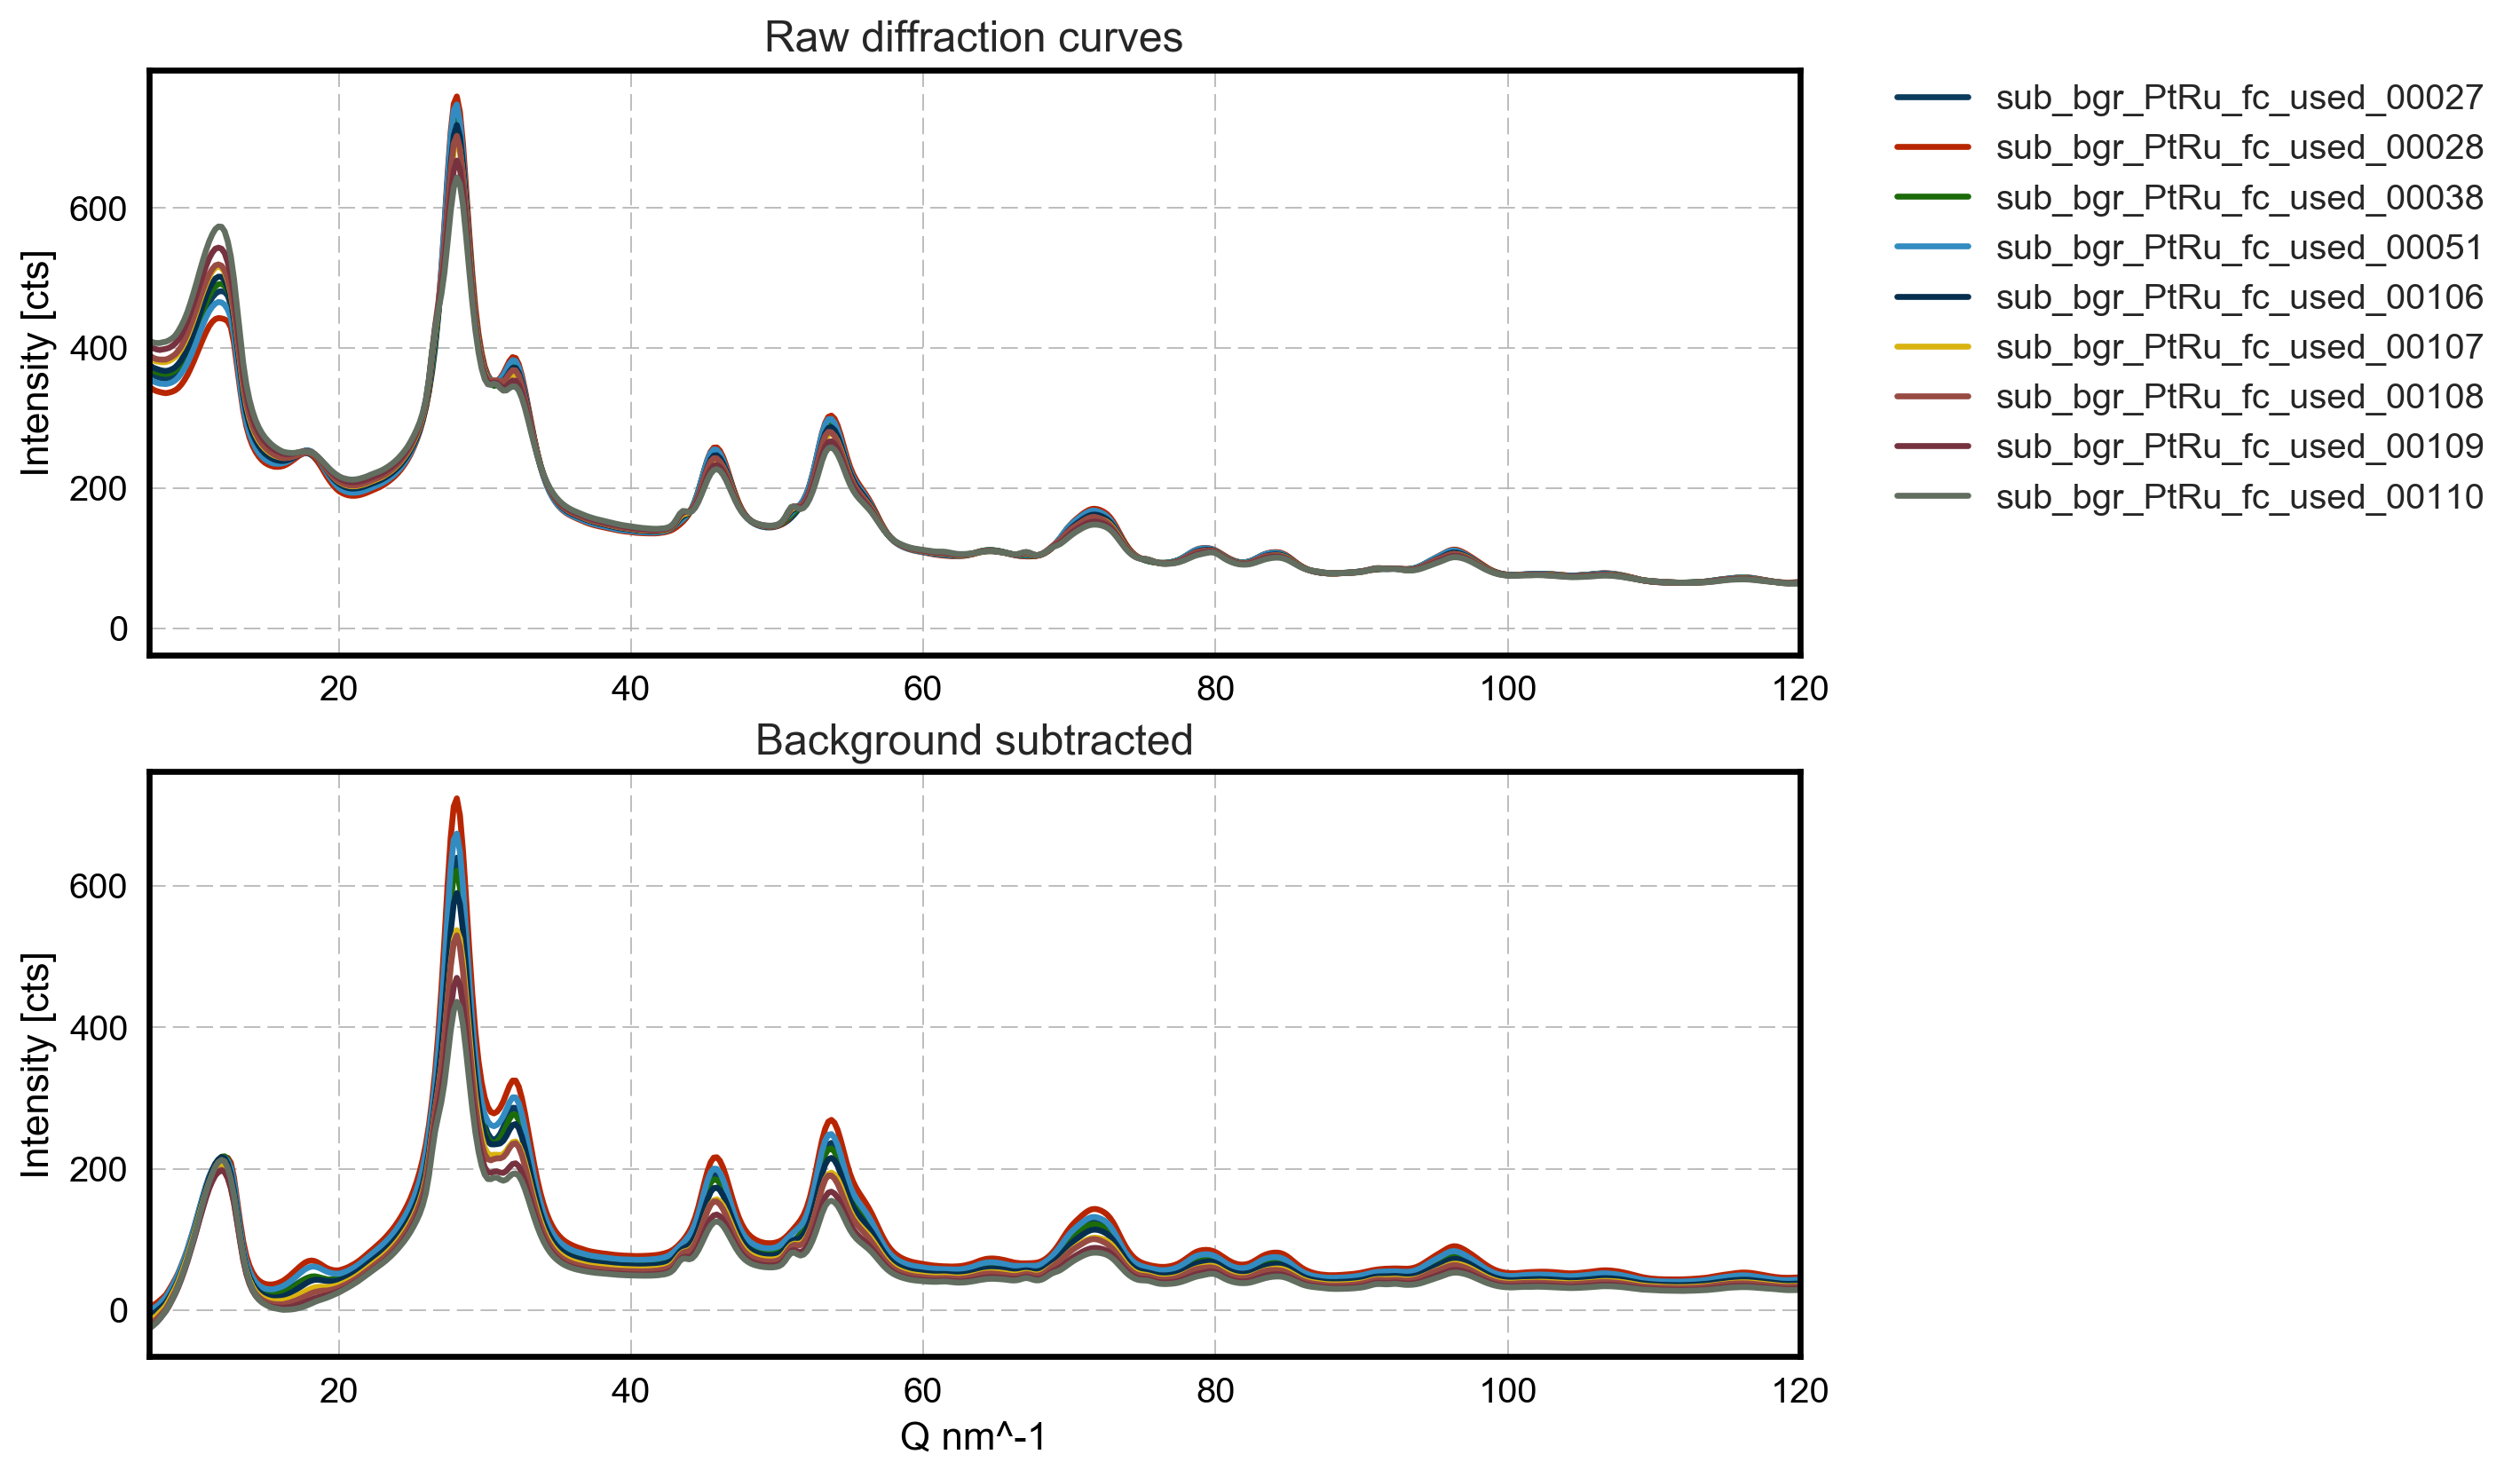

In [225]:
fig, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=[10,8])
bSeabornStyle(cycle='simon2', f_scale=1.2)        
# Use another SNS preset: deep, muted, bright, pastel, dark, colorblind

for d in event_list:
    if d['rw']>0.17:
        if d['rw']<0.2:
            ax1.plot(d['q'],scalebtoa(d['q'],event_list[26]['I'],d['I'],rmin=100,rmax=300),label='sub_bgr_'+d['basename'],lw=2)
            ax2.plot(d['q'],d['I_sub'],label='sub_bgr_'+d['basename'],lw=2)  # unscaled for reference


ax2.set_xlabel('Q nm^-1')
ax1.set_ylabel('Intensity [cts]')
ax2.set_ylabel('Intensity [cts]')
ax1.set_xlim(7,120)
ax2.set_xlim(7,120)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax1.set_title('Raw diffraction curves')
ax2.set_title('Background subtracted')

# plt.savefig('test'+well+'_'+savefigure_name+'.pdf',format='pdf')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 9.081627
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 14.228990
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 11.490917
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1050.456534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 98.749252
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 253.693396
         Iterations: 14
         Function evaluations: 28
Optimization terminated su

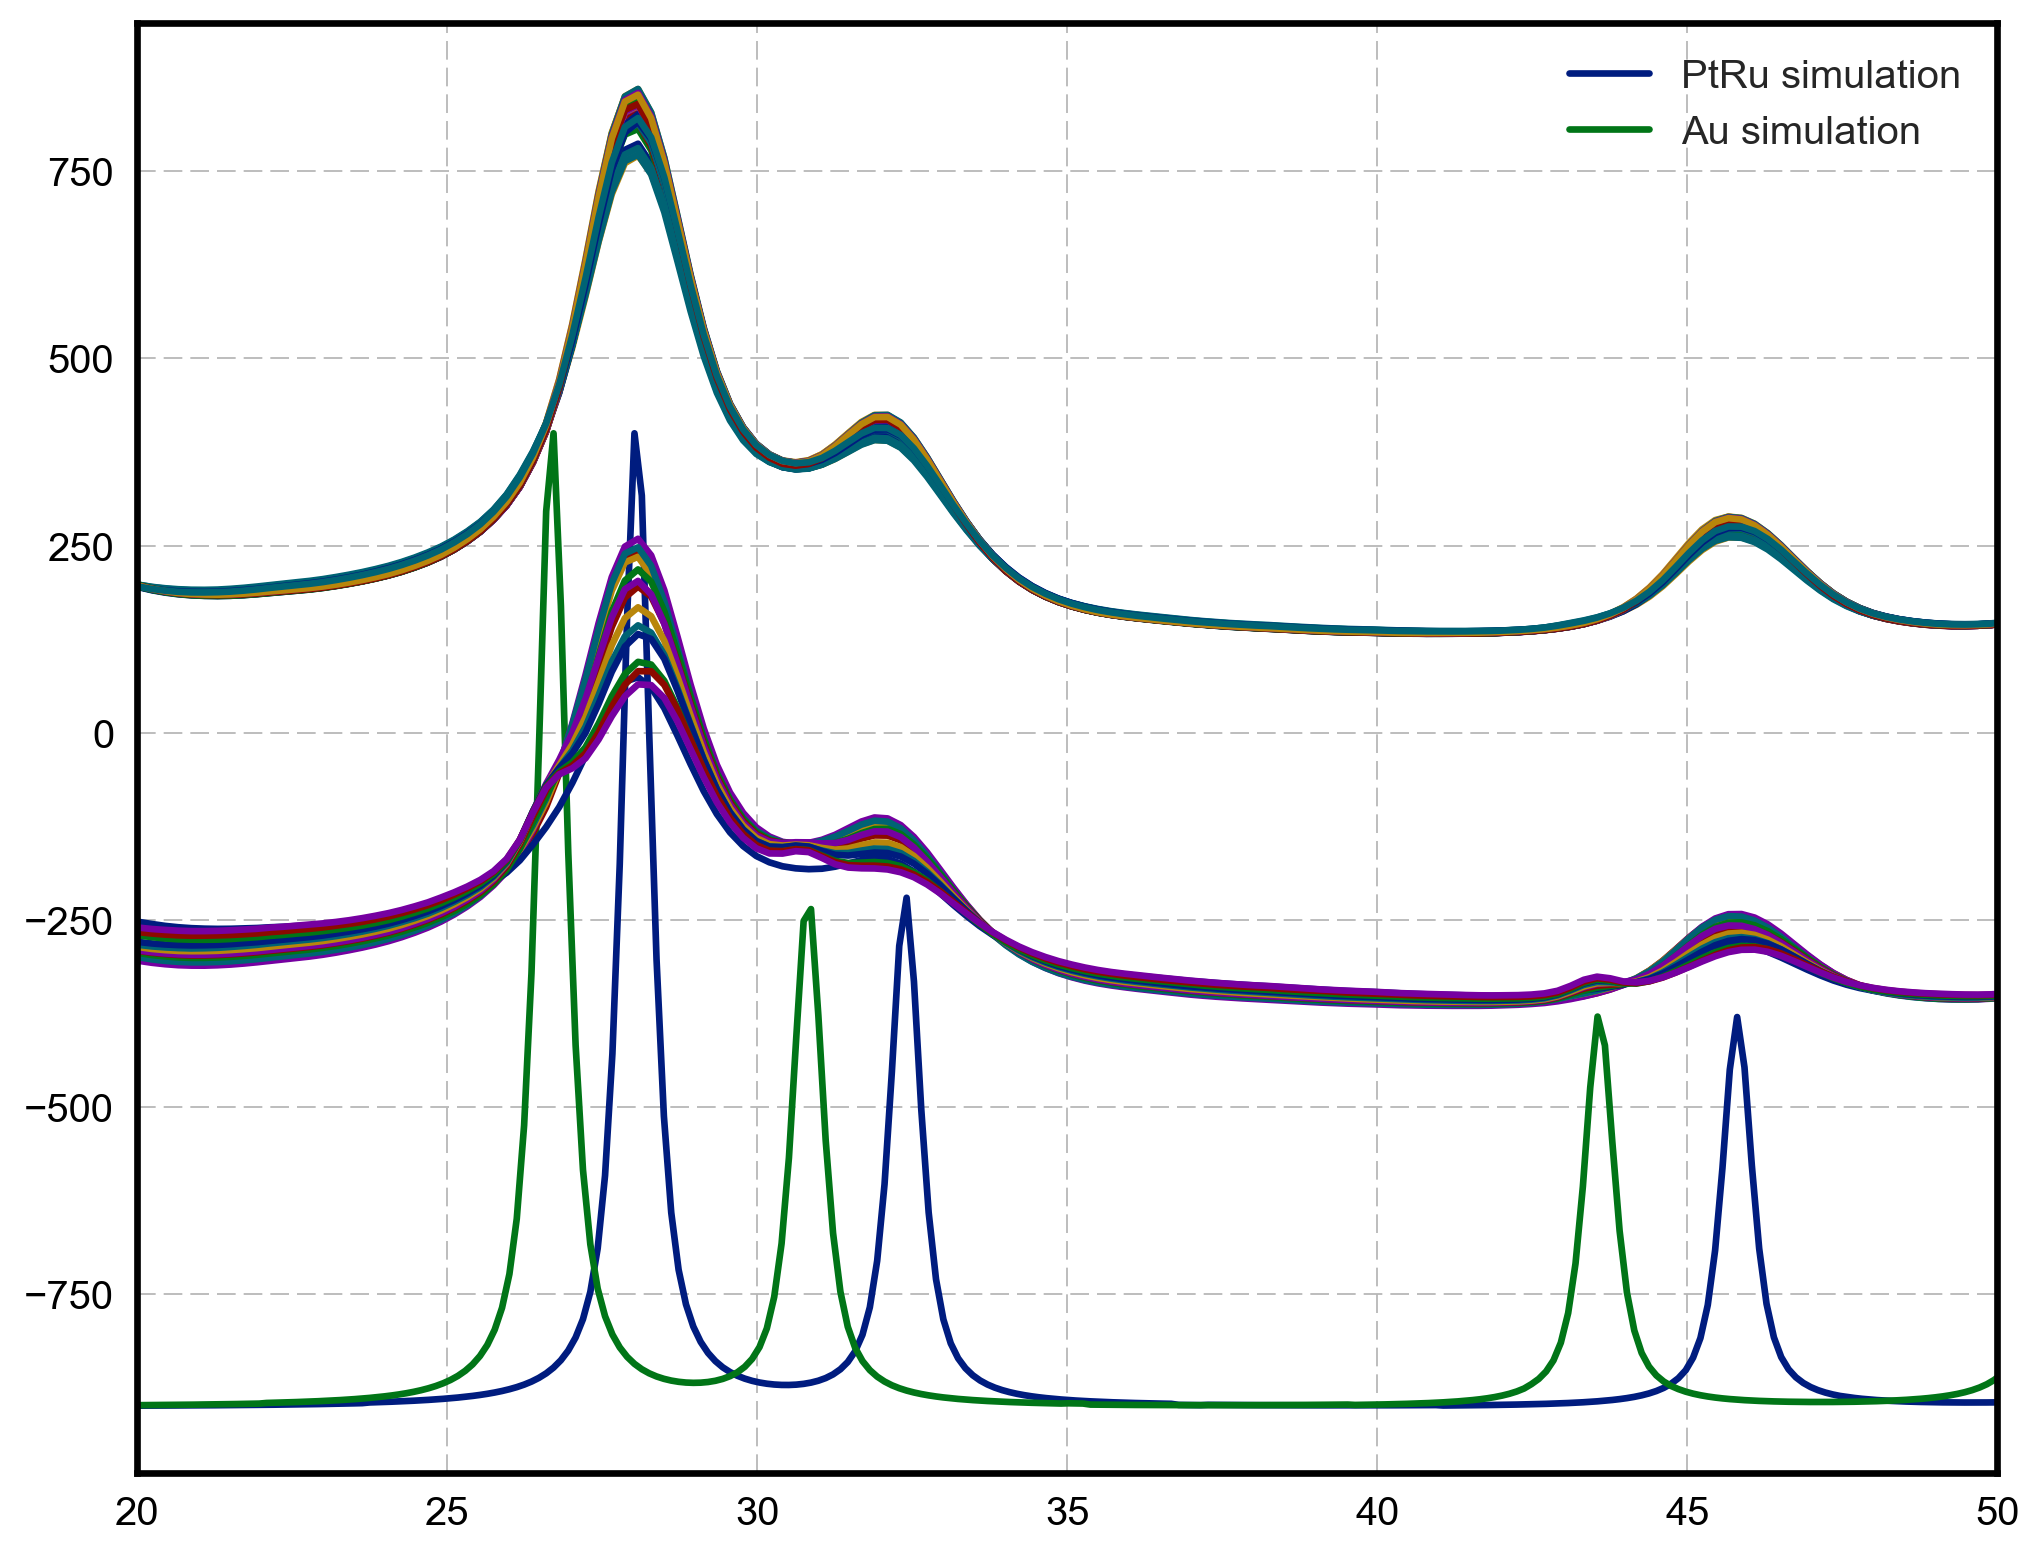

In [256]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=[10,8])
bSeabornStyle(cycle='dark', f_scale=1.2)
# Use another SNS preset: deep, muted, bright, pastel, dark, colorblind


theta2,I_2theta,error = np.genfromtxt('../PtRu_march2017/PtRu_metal_powder_spectrum.xye',skip_header=4).T # transpose 

ax1.plot(theta2_to_q(theta2,0.1847)*10,I_2theta*0.13-900,label='PtRu simulation')

theta2,I_2theta,error = np.genfromtxt('../PtRu_march2017/Au_metal_powder_spectrum.xye',skip_header=4).T # transpose 

ax1.plot(theta2_to_q(theta2,0.1847)*10,I_2theta*0.13-900,label='Au simulation')



for d in event_list:
    if d['rw']>0.17:
        if d['rw']<0.25:
            ax1.plot(d['q'],scalebtoa(d['q'],event_list[26]['I'],d['I'],rmin=100,rmax=300)-500)
#                      ,label='sub_bgr_'+d['basename'],lw=2);

            
for d in event_list:
    if d['rw']<0.17:
        ax1.plot(d['q'],scalebtoa(d['q'],event_list[26]['I'],d['I'],rmin=100,rmax=300))
#                  ,label='sub_bgr_'+d['basename'],lw=2);
        
ax1.set_xlim(20,50)
# ax1.set_ylim(-200,600)
                     
ax1.legend()

In [211]:
scalebtoa(d['q'],event_list[0]['I'],d['I'],rmin=50,rmax=150)

Optimization terminated successfully.
         Current function value: 12.654483
         Iterations: 13
         Function evaluations: 26
scale =  0.94814453125


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

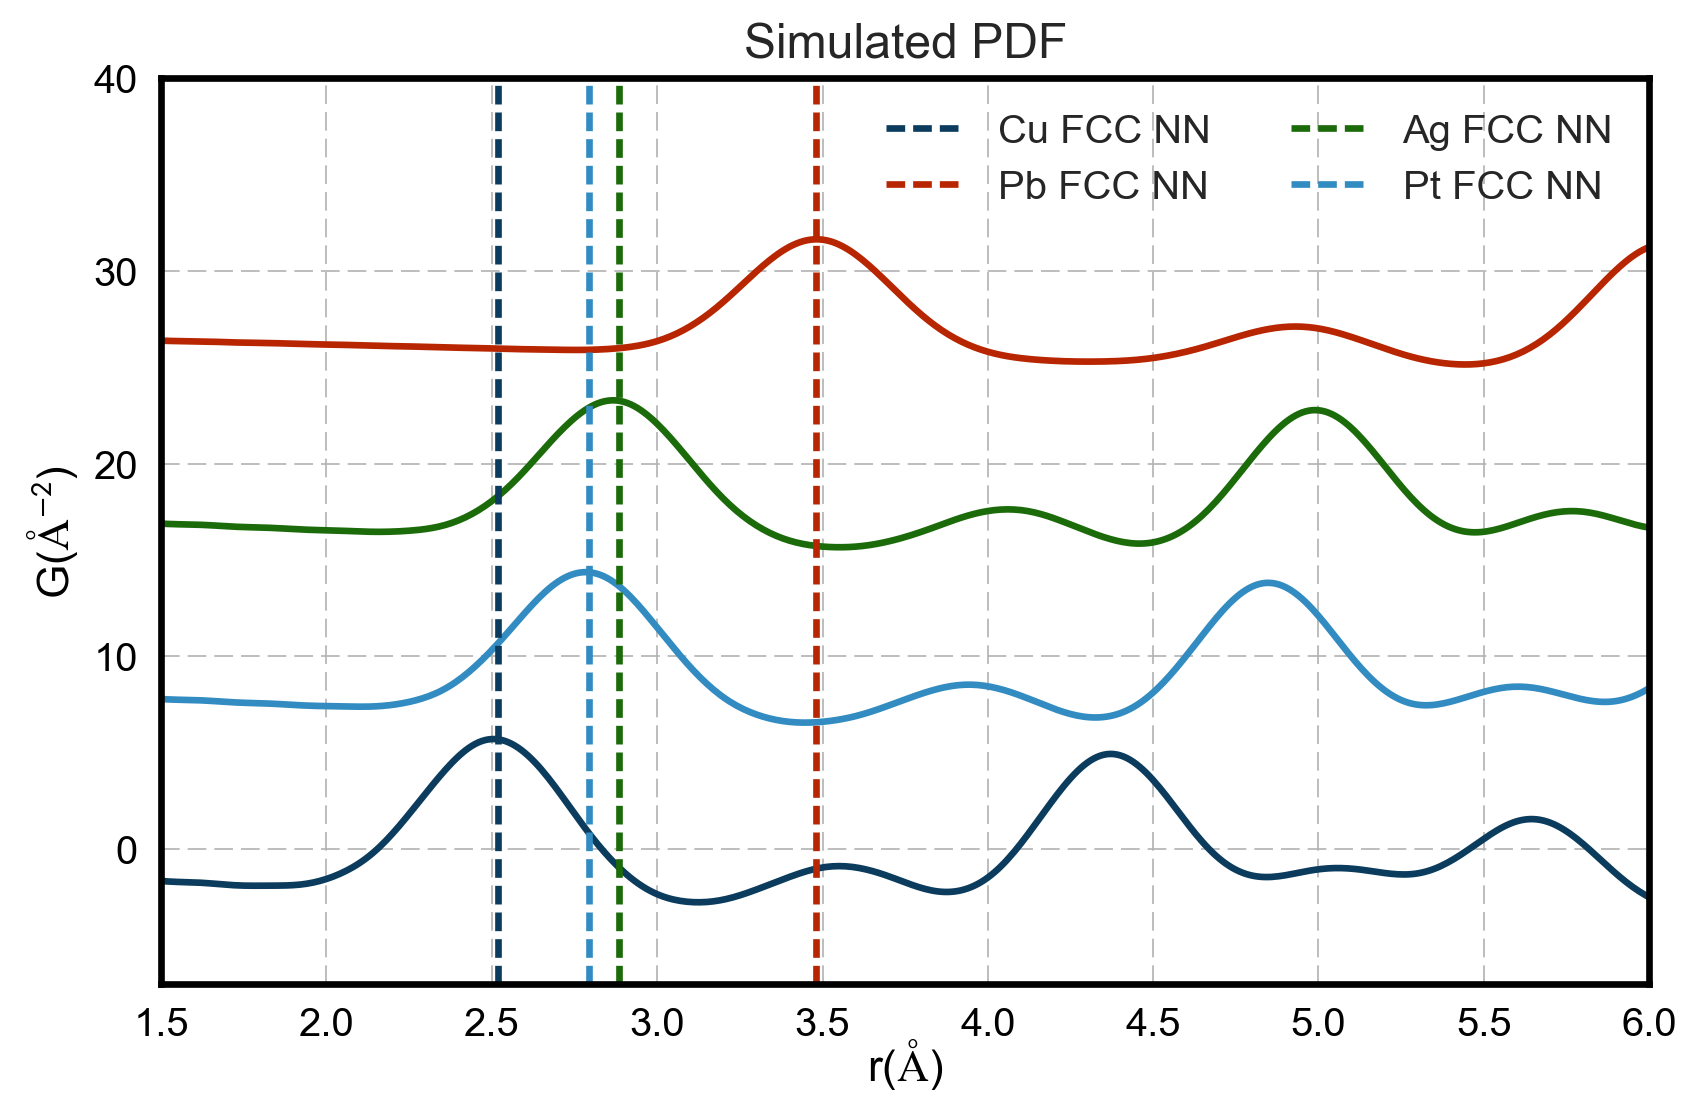

In [78]:
###
bSeabornStyle(cycle='simon2', f_scale=1.2)
fig, ((ax1)) = plt.subplots(1, 1, figsize=[8,5])#,gridspec_kw = {'height_ratios':[2, 1]})
r, gr1,gr2,gr3,gr4 = np.genfromtxt('./residue_check/phase_sim',skip_header=4).T # transpose 

# ax2.plot(q,fq)

ax1.plot(r,gr1) 
ax1.plot(r,gr2+27) 
ax1.plot(r,gr3+18)
ax1.plot(r,gr4+9)
      
ax1.set_xlim([1.5,6])
# ax2.set_xlim([1.5,6])

ax1.set_ylim([-7,40])
# ax2.set_ylim([-7,12.5])

# ax1.set_xlabel('q($\mathrm{nm ^{-1}}$)')
ax1.set_ylabel('I ($cts$)')

ax1.set_xlabel('r($\mathrm{\AA}$)')
ax1.set_ylabel('G($\mathrm{\AA}$$^{-2}$)') 
# ax2.set_xlabel('r($\mathrm{\AA}$)')
# ax2.set_ylabel('G($\mathrm{\AA}$$^{-2}$)')

ax1.axvline(np.sqrt(2)/2*3.56, label = 'Cu FCC NN', ls='--',color='#0B3C5D')
ax1.axvline(np.sqrt(2)/2*4.92, label = 'Pb FCC NN', ls='--',color='#B82601')
ax1.axvline(np.sqrt(2)/2*4.08, label = 'Ag FCC NN', ls='--',color='#1c6b0a')
ax1.axvline(np.sqrt(2)/2*3.95, label = 'Pt FCC NN', ls='--',color='#328CC1')

ax2.axvline(np.sqrt(2)/2*4.076, label = 'Catalyst Array NN', ls='--',color ='g')

ax1.set_title('Simulated PDF')
# ax2.set_title('Experimental PDF')
ax1.xaxis.labelpad=-2.5
# ax2.xaxis.labelpad=-2.5
ax1.legend(ncol=2)
# ax2.legend()
# plt.savefig(sample_name+'overlay'+'.pdf',format='pdf')
# ax1.xaxis.labelpad=-2
# ax2.xaxis.labelpad=-2
# fig.subplots_adjust(hspace=0.19

#     elif cycle=='simon2':
#         simonCycle2 = ["#0B3C5D", "#B82601",  "#1c6b0a","#328CC1", "#062F4F", "#D9B310", "#984B43",
#                  "#76323F", "#626E60", "#AB987A", "#C09F80", "#b0b0b0ff"]    

(0, './large_array/sub_20170324-204924_array_Au_ct_10.0_631130.chi')
(1, './large_array/sub_20170324-205134_array_Ti_ct_30.0_775e20.chi')
(2, './large_array/sub_20170324-205648_array_Re_ct_30.0_c1a2af.chi')
(3, './large_array/sub_20170324-210119_array_Ir_ct_10.0_af5d78.chi')
(4, './large_array/sub_20170324-210425_array_Ru_ct_30.0_8e12f9.chi')
(5, './large_array/sub_20170324-210812_array_Pt_ct_30.0_24667a.chi')
(6, './large_array/sub_20170324-211100_array_Fe_ct_30.0_e49e50.chi')
(7, './large_array/sub_20170324-211538_array_Ni_ct_30.0_b555fd.chi')
(8, './large_array/sub_20170324-213932_array_Cu_ct_30.0_c04f42.chi')
(9, './large_array/sub_20170324-214635_array_Ag_ct_30.0_f1d211.chi')


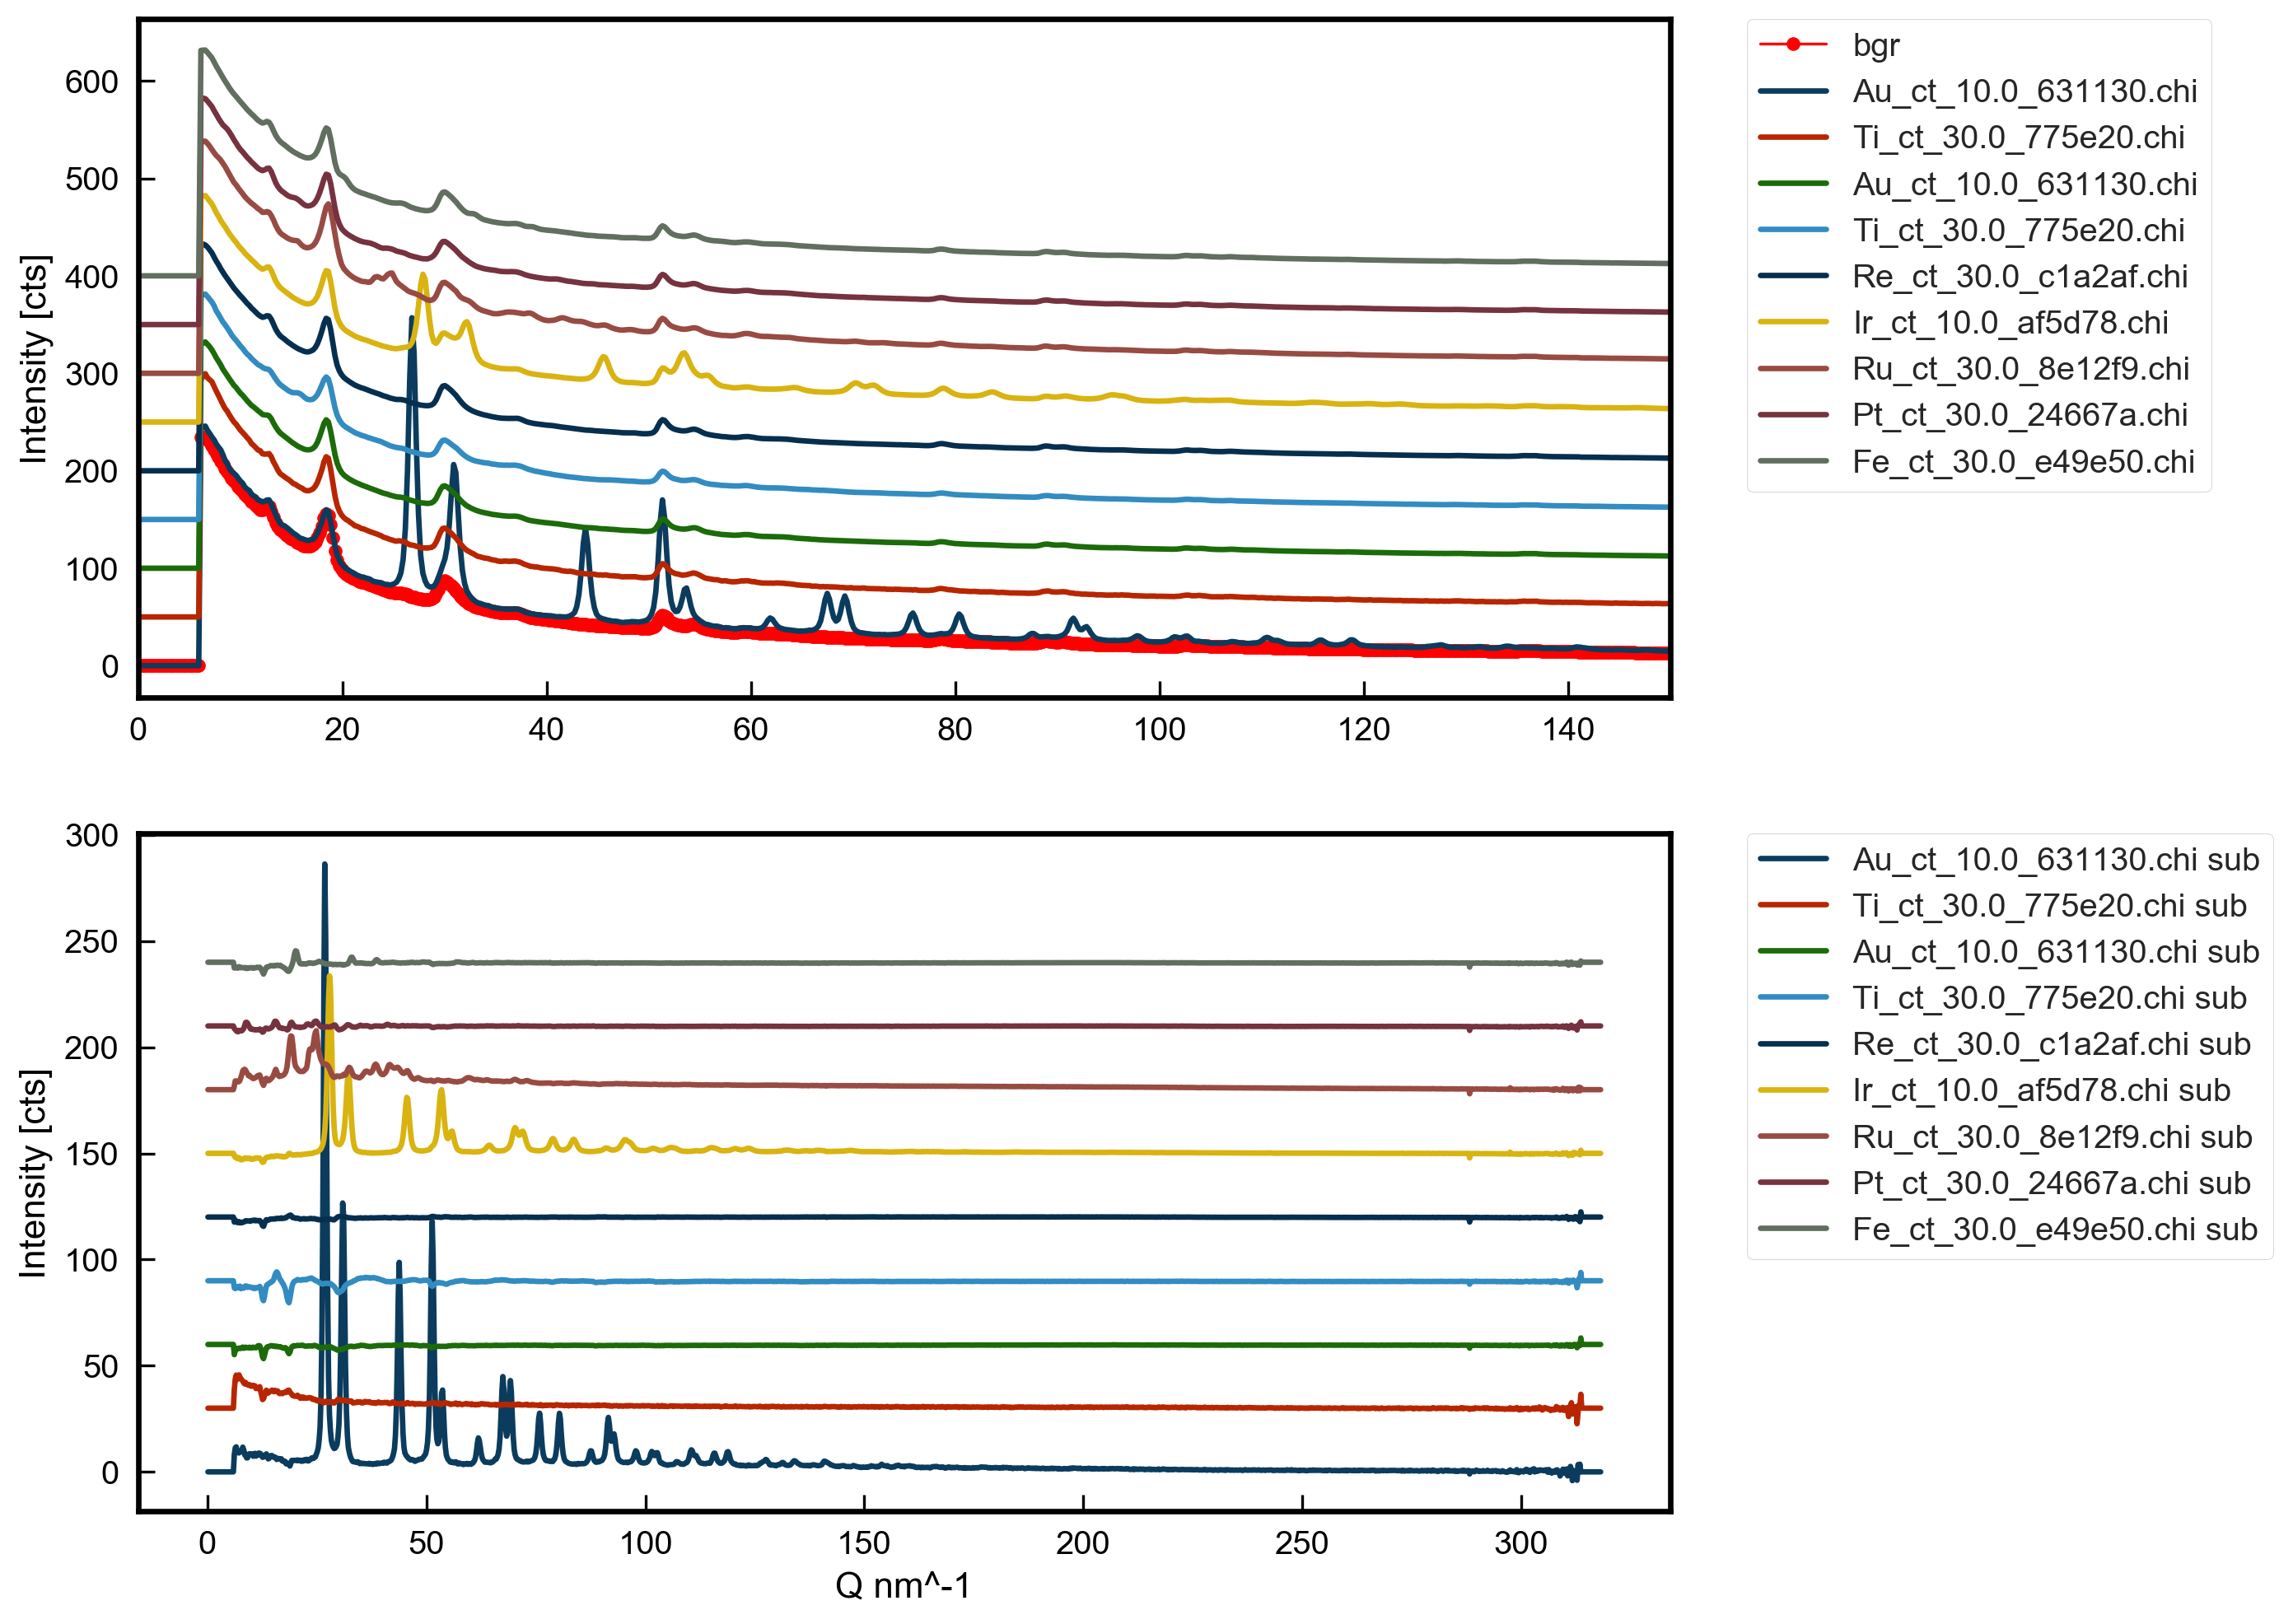

In [139]:
fig, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=[10,10])

large_array_files = sorted(glob('./large_array/'+'*.chi'))
large_array_filenames = [j.lstrip('./large_array/sub_20170324-9658') for j in large_array_files]

q_bgr,iq_bgr = np.genfromtxt('./array_background.chi',skip_header=4).T # transpose 
ax1.plot(q_bgr,iq_bgr,label='bgr',color = 'r',lw=1,marker='o')

for idx, val in enumerate(large_array_files):
    print(idx, val)
# print large_array_files


for i,j in enumerate(large_array_files[0:2]):
    q, iq = np.genfromtxt('./'+j,skip_header=4).T # transpose 
    ax1.plot(q,iq*4+i*50,label = large_array_filenames[i])
    ax2.plot(q,iq*4-iq_bgr+(i)*30,label = large_array_filenames[i]+' sub')


for i,j in enumerate(large_array_files[2:9]):
    q, iq = np.genfromtxt('./'+j,skip_header=4).T # transpose 
    ax1.plot(q,iq+(i+2)*50,label = large_array_filenames[i])
    ax2.plot(q,iq-iq_bgr+(i+2)*30,label = large_array_filenames[i]+' sub')


# for d in event_list[44:50]:
#     ax1.plot(d['q'],d['I'],label='sub_bgr_'+d['basename'],lw=1)
#     ax2.plot(d['q'],d['I_sub'],label='sub_bgr_'+d['basename'],lw=1)  # unscaled for reference
    
# # #plot background
# # ax1.plot(qgrid_bgr,I_bgr,'ro',ms=2,label='background')
# # #plot the data file
# # ax1.plot(qgrid_data,I,label=basename,lw=1);
# # #plot subtracted data
# ax1.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)
# ax2.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)  # unscaled for reference
# #plot scaled data with an offset
# ax2.plot(qgrid_data,I_subtr_resc-200,label='scale_sub_bgr_'+basename,lw=1)

# #configure plots
    # add axis labels using proper greek letters
ax2.set_xlabel('Q nm^-1')
ax1.set_ylabel('Intensity [cts]')
ax2.set_ylabel('Intensity [cts]')


ax1.set_xlim([0,150])

    #add legend from filename
    #     ax1.legend()
    #     ax2.legend()

    #     ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #     ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=True)
# plt.title(savefigure_name+' '+'well '+well)


# plt.savefig('test'+well+'_'+savefigure_name+'.pdf',format='pdf')

# Pearson r

In [90]:
## Load background
qgrid_bgr,I_bgr = np.genfromtxt(path_to_bgr,skip_header=4).T # transpose

for d in event_list:
#     pearson_map1 = pearsonr(d['I'], event_list[0]['I'])
    pearson1 = pearsonr(d['I'], I_bgr)
    d['pearsonr'] = pearson1[0]
#     print d['pearsonr']
# print d['I'][0:]
# print event_list[0]['I']
# pearson_map2 = np.apply_along_axis(pearsonr, 1, Iq_array, bkg_Iq)

0.999890909621
0.999945132867
0.999963137884
0.999781327692
0.999979608782
0.999880271772
0.9999610047
0.999964110013
0.999948424496
0.999981919597
0.999984819777
0.999943832447
0.999983371855
0.999975981353
0.999959362741
0.999871069497
0.999979463694
0.999950986033
0.999938263045
0.999847696608
0.99954282885
0.998087917846
0.999713889603
0.999928797907
0.999835312966
0.998181860715
0.999277267209
0.99033370629
0.995117842384
0.998180445757
0.988581824874
0.996533358262
0.988120823258
0.999758786017
0.998270616624
0.992482582066
0.999788604906
0.999084446901
0.995118541631
0.961484621665
0.996102927243
0.958280342129
0.997058893303
0.997016298003
0.997831269456
0.997541734203
0.999224567305
0.995869102469
0.954451336596
0.999045309441
0.965974939779
0.975200959448
0.989226019479
0.999971419807
0.999941120924
0.999916737287
0.99983691019
0.992841204615
0.951076344173
0.975996538241
0.887756660133
0.873310648534
0.990174276625
0.993892732322
0.978467023033
0.966919729667
0.983184762818


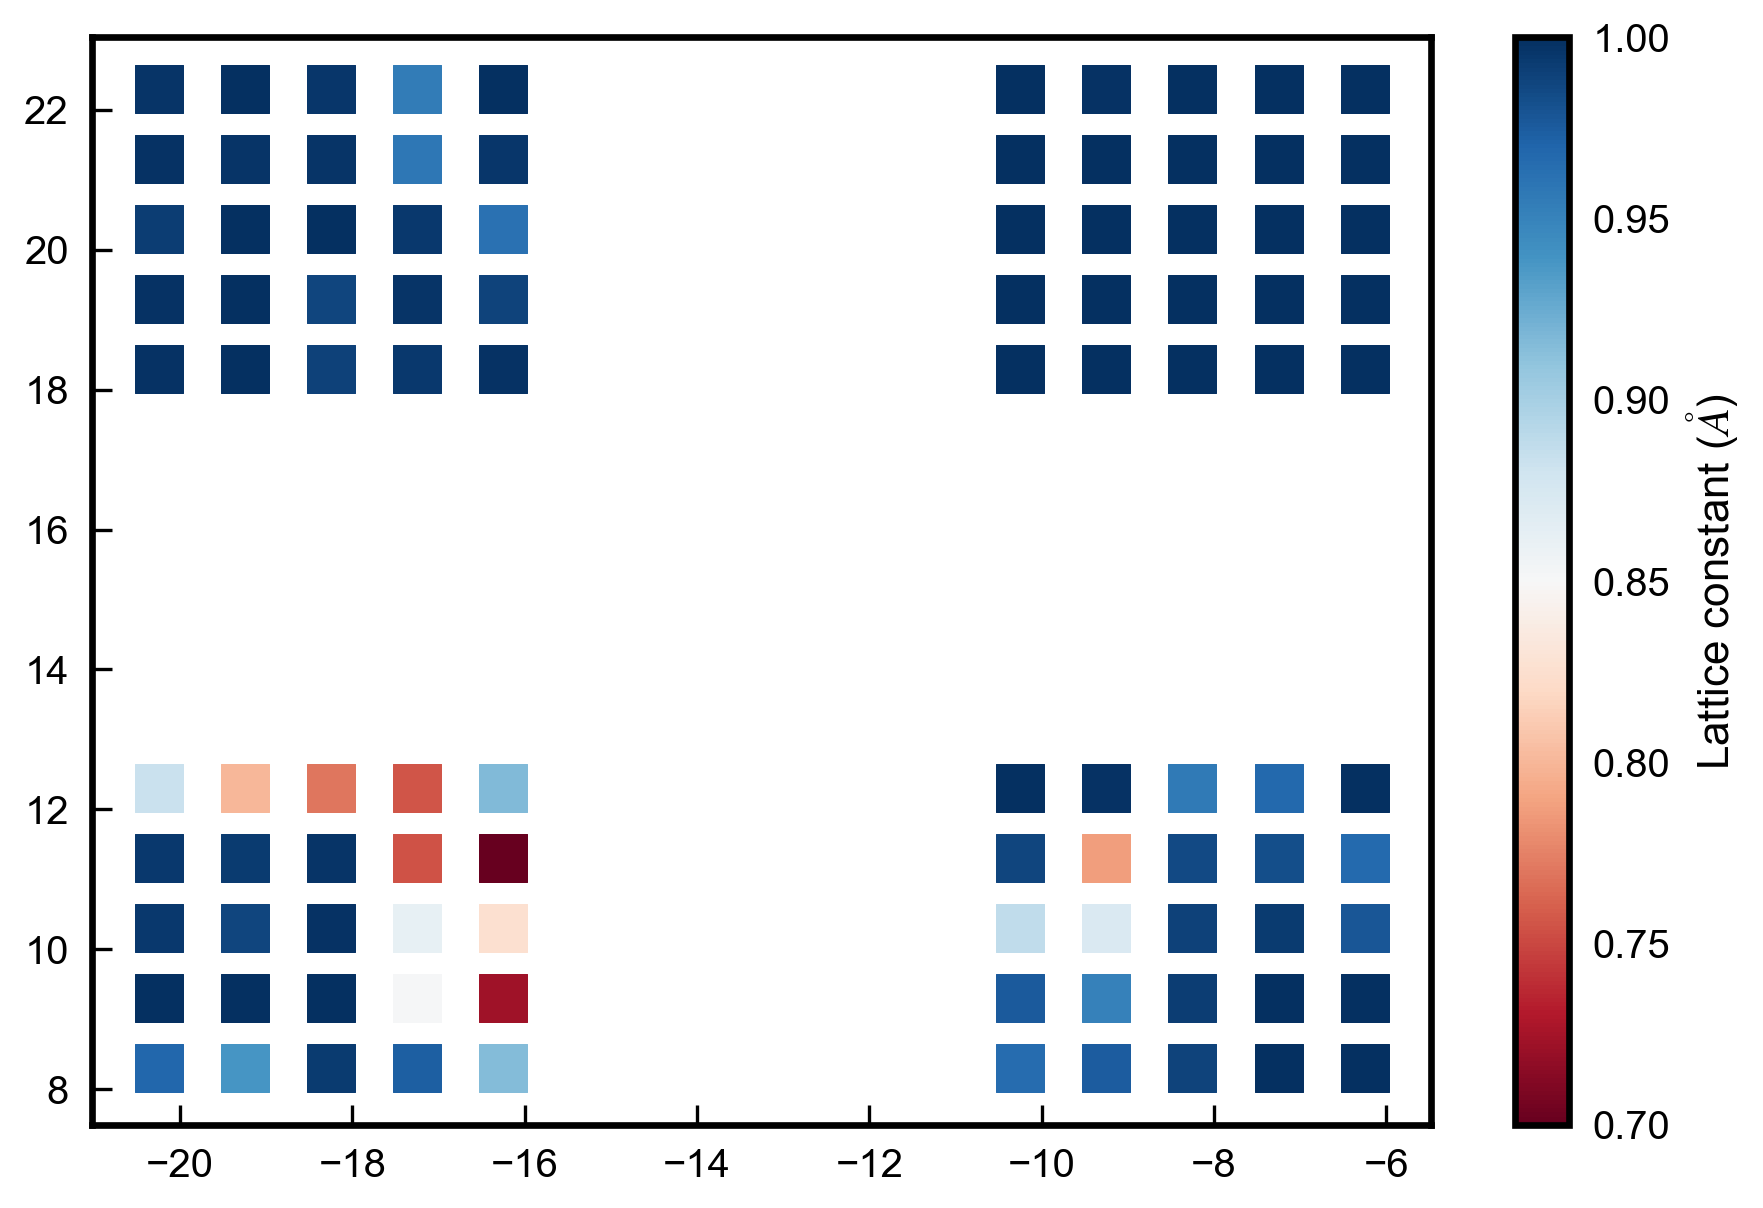

In [91]:
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)


# create scatter plot with pearson map
# fig, ax = plt.subplots(1,1, figsize=(15,9), sharey=True)
fig.suptitle('Pearson Map')
# cax = fig.add_axes((0.93,0.1,0.03,0.8))
for d in event_list:
    plt.scatter(d['x'], d['y'], c=d['pearsonr'],cmap = 'RdBu',vmin = 0.7, vmax = 1,marker = 's', s = 200)
# ax[1].scatter(df['diff_x'], df['diff_y'], c=pearson_map2[:,0])
# fig.colorbar(im, cax=cax)

# ax.set_title('wrt corner mearsurement')
# ax[1].set_title('wrt underlying background')
# for el in ax:
#     el.set_xlabel('diff_x readback value')
#     el.set_ylabel('diff_y readback value')
# plt.set_cmap('inferno')
plot = plt.colorbar()
plot.set_label('Lattice constant ($\AA$)')



# for d in event_list[0:100]:
#     plt.scatter(d['x'], d['y'], c=d['lattice constant'],cmap = 'RdBu_r', vmin = 3.58, vmax = 4.9, marker = 's')

# plt.xlim(-21,-5.5)
# plt.ylim(7.5,23)

# # plt.gca().invert_yaxis()
# # plt.gca().invert_xaxis()
# plt.ylabel('y motor [mm]')
# plt.xlabel('x motor [mm]')

# plot = plt.colorbar()
# plot.set_label('Lattice constant ($\AA$)')

In [92]:
df = pd.DataFrame(event_list)
# df.head()

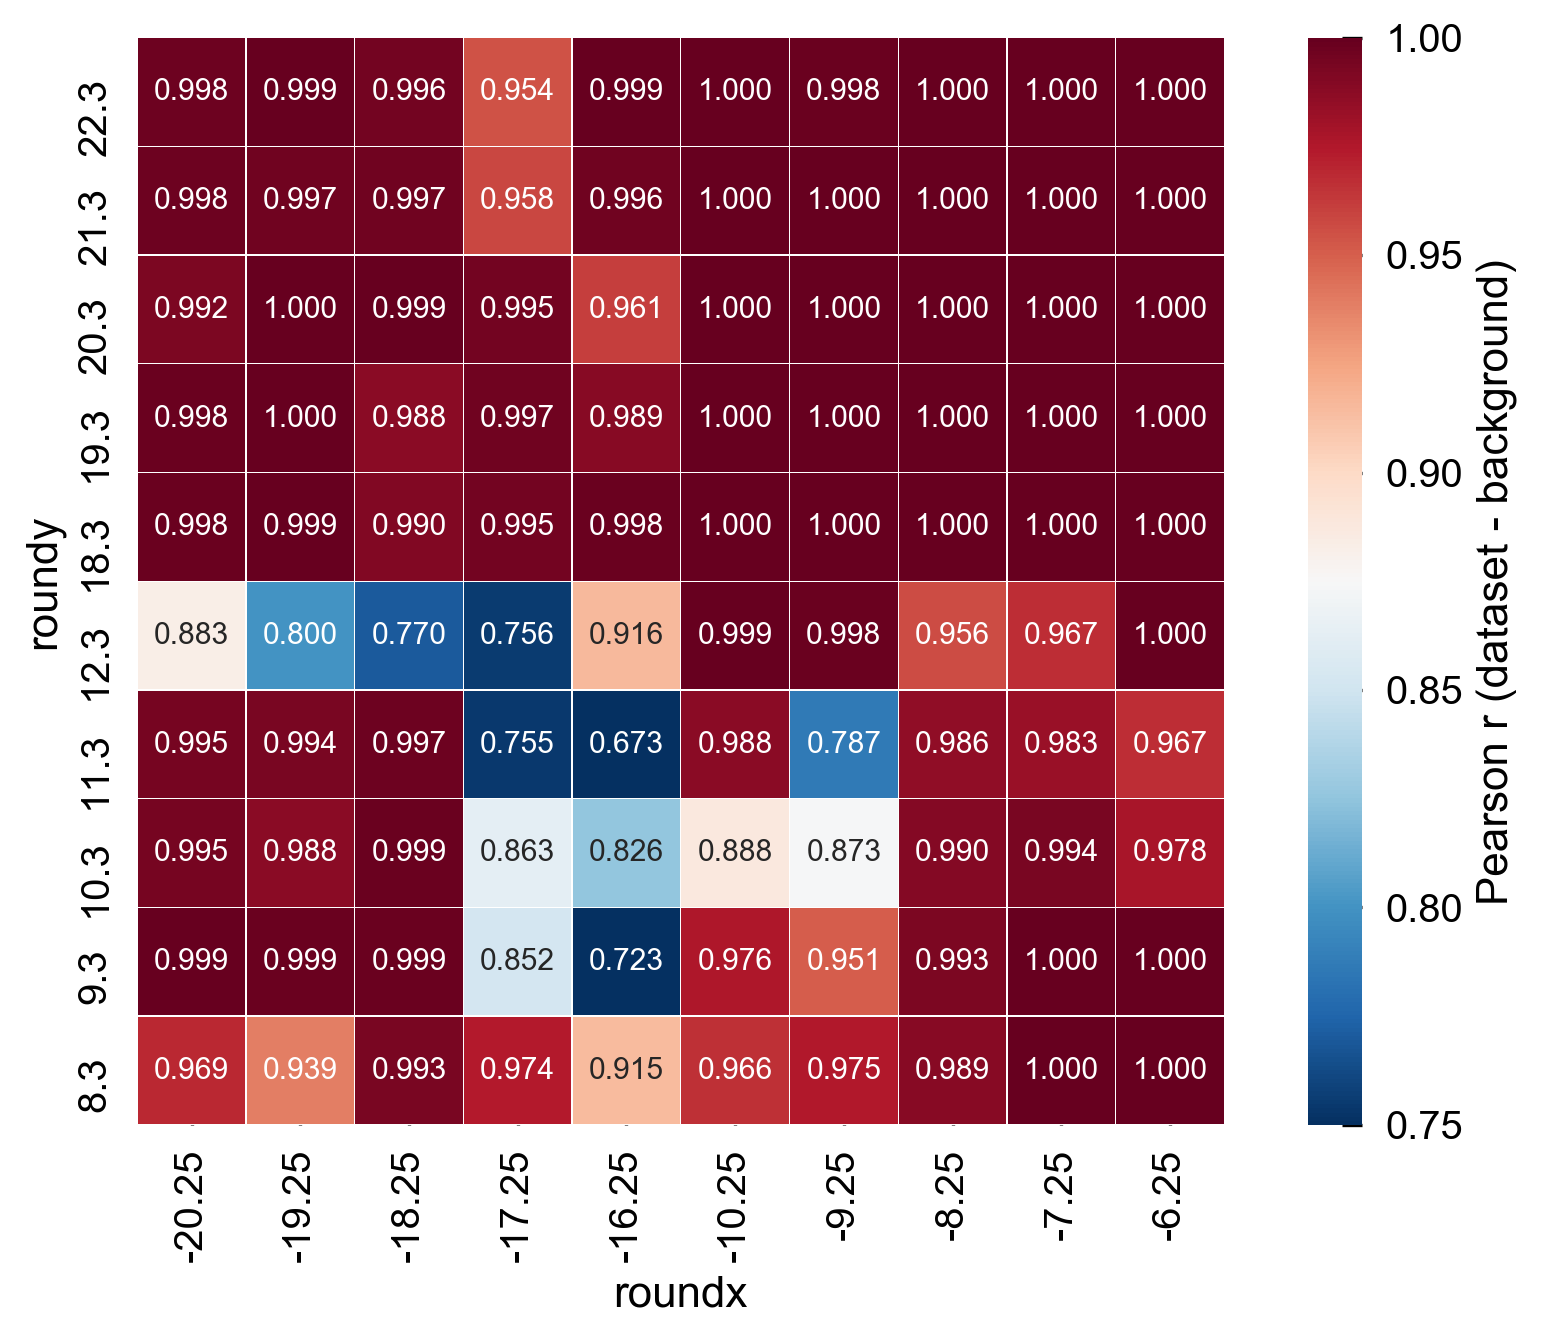

In [106]:
# plt.figure(figsize=(14,6))
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.2)
grid_heatmap_2 = (df.pivot('roundx','roundy','psize'))

pivot = pd.pivot_table(df,values='pearsonr',index='roundy',columns='roundx')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".3f", 
            linewidths=0.1, square = True, cbar = True,cmap = 'RdBu_r',vmin = 0.75,vmax = 1,
                cbar_kws={'label': 'Pearson r (dataset - background)'});
ax.invert_yaxis()
# # ax.invert_xaxis()
# # ax.invert_yaxis()
# plt.savefig('E075A_phase.pdf',format='pdf')
# sns.heatmap([df.y, df.x], annot=True)